In [102]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
from datetime import datetime, timedelta
import pytz as pytz
import sys
import os
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
import modules.thermolib as thermo
import modules.DSDlib as dsd
import modules.disdrometer_module as dis
import modules.plotmodule as pm
import modules.simulator as sim
from modules.datahandler import getDataHandler
import pandas as pd
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from metpy.plots import ctables
# Weird that you have to do this twice...
%matplotlib notebook
%matplotlib notebook 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Some global parameters
rhoacst = 1.0 # kg m^-3
cr = 1000.*np.pi/6.

sampling_area = dis.sensor_area
sampling_width = dis.sensor_width
sampling_length = dis.sensor_length

In [3]:
# Function definitions
def plotDSD(Dl, Dmid, Dr, ND, ax=None):
    """Plots a DSD on a semilog plot"""
    if ax is None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
    ax.bar(Dl, ND, Dr-Dl, 10.**2., align='edge', log=True, color='tan', edgecolor = 'k')
    ax.set_yscale('log')
    ax.set_ylim(10.**2., 10.**8.5)
    ax.set_xlim(0., 9.)
    ax.set_xlabel('D (mm)')
    ax.set_ylabel(r'N(D) $(m^{-4})$')
    
    return ax

def plotVD(Dl, Dmid, Vl, countsMatrix, Vt_fit, ax=None, strongwindflag=False):
    """Plot drop counts in each velocity/diameter bin for a given DSD"""
    if ax is None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
    countsplot = ma.masked_where(countsMatrix <= 0, countsMatrix)

    C = ax.pcolor(Dl, Vl, countsplot, vmin=1, vmax=50, edgecolors='w')
    ax.plot(Dmid, Vt_fit, c='r')
    # ax1.scatter(X[0:10,20:31],Y[0:10,20:31],c='r',marker='x')
    fig.colorbar(C)

    if(strongwindflag):
        ax.text(0.5, 0.5, 'Flagged for strong wind contamination!',
                 horizontalalignment='center',
                 verticalalignment='center', color='y',
                 transform=ax.transAxes)
#     if(plot_strongwindQC):
#         ax1.scatter(X[strongwindmask], Y[strongwindmask], c='r', marker='x', alpha=1.0)
#     if(plot_splashingQC):
#         ax1.scatter(X[splashmask], Y[splashmask], c='w', marker='o', alpha=0.75)
#         # ax1.pcolor(min_diameter,min_fall_bins,ma.masked_array(splashmask,mask=-splashmask),cmap=cm.Reds,alpha=0.1)
#     if(plot_marginQC):
#         ax1.scatter(X[marginmask], Y[marginmask], c='g', marker='x', alpha=0.1)
#         # ax1.pcolor(min_diameter,min_fall_bins,ma.masked_array(marginmask,mask=-marginmask),cmap=cm.Reds,alpha=0.1)
#     if(plot_rainfallspeedQC):
#         ax1.scatter(X[fallspeedmask], Y[fallspeedmask], c='k', marker='x', alpha=0.5)
#         # ax1.pcolor(min_diameter,min_fall_bins,ma.masked_array(fallspeedmask,mask=-fallspeedmask),cmap=cm.gray,alpha=0.1)
#     if(plot_rainonlyQC):
#         ax1.scatter(X[rainonlymask], Y[rainonlymask], c='g', marker='x', alpha=0.5)

    ax.set_xlim(0.0, 9.0)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
    ax.set_xlabel('D (mm)')
    ax.set_ylim(0.0, 15.0)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1.0))
    ax.set_ylabel(r'V$_T$ (m s$^{-1}$)')

In [4]:
D = dis.avg_diameter/1000.
Dl = dis.min_diameter/1000.
Dr = dis.max_diameter/1000.

Dedges = np.append(Dl,Dr[-1])
print Dedges

qr = 1.0 # g kg^-1
N0r = 8.0e6 # M-P value (m^-4)

ND, Ntr, lamdar, alphar = dsd.gammaDSD(rhoacst, D, cr, qr, N0=N0r)
print Ntr

ND_sample = sim.samplegammaDSD(Ntr, lamdar, alphar, bins=Dedges)

print ND
print ND_sample

[0.       0.000125 0.00025  0.000375 0.0005   0.000625 0.00075  0.000875
 0.001    0.001125 0.00125  0.0015   0.00175  0.002    0.00225  0.0025
 0.003    0.0035   0.004    0.0045   0.005    0.006    0.007    0.008
 0.009    0.01     0.012    0.014    0.016    0.018    0.02     0.023
 0.026   ]
3572.9753669520087
[6.95528742e+06 5.25733038e+06 3.97388650e+06 3.00376289e+06
 2.27047036e+06 1.71619260e+06 1.29722770e+06 9.80542454e+05
 7.41167880e+05 5.60230539e+05 3.68164629e+05 2.10349963e+05
 1.20182938e+05 6.86662284e+04 3.92322821e+04 1.69431493e+04
 5.53088834e+03 1.80549232e+03 5.89381365e+02 1.92396494e+02
 3.58837884e+01 3.82384074e+00 4.07475315e-01 4.34212992e-02
 4.62705138e-03 1.60955783e-04 1.82771975e-06 2.07545166e-08
 2.35676153e-10 2.67620056e-12 9.92024574e-15 1.20040268e-17]
[6.896e+06 5.240e+06 4.016e+06 3.064e+06 2.184e+06 1.680e+06 1.288e+06
 9.840e+05 7.280e+05 6.720e+05 4.400e+05 1.880e+05 1.080e+05 8.000e+04
 2.400e+04 2.200e+04 1.000e+04 2.000e+03 0.000e+00 2.00

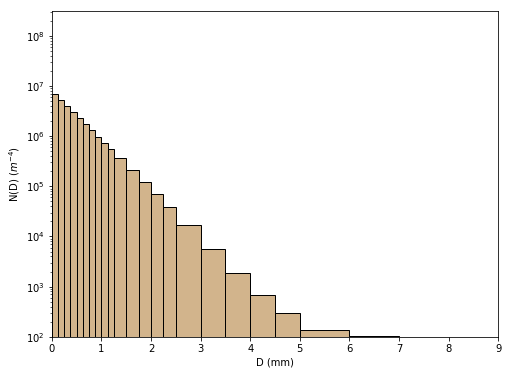

In [5]:
ax = plotDSD(Dl*1000., D*1000., Dr*1000., ND)

Dmax_index =  29
sampling height =  103.93760814600546
sampling volume =  0.5612630839884294
number concentration =  3572.9753669520087
number of particles in sampling volume =  2005
minimum, maximum diameter in sample =  1.2796219433280825e-07 0.0034289151167594283
maximumm allowed diameter =  0.02
number of particles less than Dmax =  2005
number of particles above the lowest two bins =  1103
number of particles within allowable diameter range =  1103
minimum, maximum particle diameter in truncated sample =  0.00025033750444097364 0.0034289151167594283
number of particles that fall through sampling area =  328
number of these that are margin fallers =  11
Removing margin fallers!


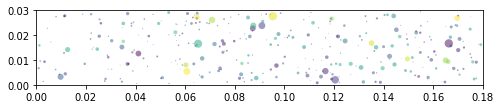

In [16]:
remove_margins = True
Vtr = dis.assignfallspeed(dis.avg_diameter, rhocorrect=True, rho=rhoacst)
sample_dict = sim.create_random_gamma_DSD(Ntr, lamdar, alphar, Vtr, 
                                      sampling_length, sampling_width, Dl, D, Dr, verbose=True, 
                                      remove_margins=remove_margins, rhocorrect=True, rho=rhoacst)
positions = sample_dict['positions']
diameters = sample_dict['diameters']
velocities = sample_dict['velocities']
ND_sample = sample_dict['ND']
margin_mask = sample_dict['margin_mask']

positions = positions.T
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
pm.circles(positions[0], positions[1], diameters/2., c=positions[2], alpha=0.5)
if not remove_margins:
    pm.circles(positions[0][margin_mask], positions[1][margin_mask], diameters[margin_mask], c='r', alpha=1.0)
#ax.scatter(positions[0], positions[1], c=positions[2], alpha=0.5, s=diameters*1000.)
ax.set_xlim(0.0, sampling_length)
ax.set_ylim(0.0, sampling_width)
ax.set_aspect('equal')

29


<BarContainer object of 30 artists>

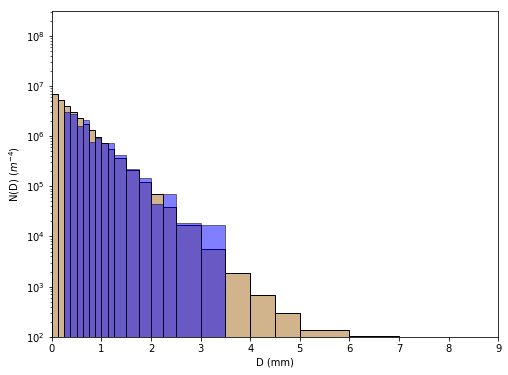

In [17]:
# Plot ND along with sampled ND
Dmax = 20.
Dmax_index = np.searchsorted(Dr, Dmax/1000.)
print Dmax_index
ax = plotDSD(Dl*1000., D*1000., Dr*1000., ND)
ax.bar(Dl[:Dmax_index+1]*1000., ND_sample, (Dr-Dl)[:Dmax_index+1]*1000., 10.**2., align='edge', log=True, color='b', edgecolor = 'k', alpha=0.5)


(0.0, 0.009)

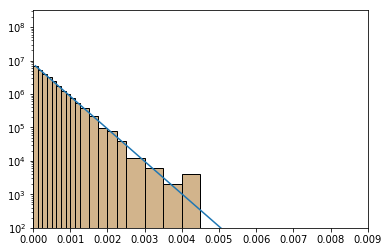

In [18]:
# Compute gamma distribution as a function of total number concentration and the PDF for the middle of each bin
shape = alphar+1
scale = 1./lamdar
x = D
s = Ntr*gamma.pdf(x, shape, scale=scale)

# Now sample the gamma distribution
s_sample = gamma.rvs(shape, scale=scale, size=int(Ntr))
# Bin up the samples into the Parsivel bins
s_binned,_ = np.histogram(s_sample, bins=Dedges)

# For plotting need to divide by the bin widths, since above we get number of drops/unit volume in each bin
# So this gives us number of drops/unit volume/diameter interval
s_sample_plot = s_binned/(Dr-Dl)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, s)
ax.bar(Dl, s_sample_plot, Dr - Dl, 10**2., align='edge', log=True, color='tan', edgecolor='k')
ax.set_yscale('log')
ax.set_ylim(10.**2.0, 10.**8.5)
ax.set_xlim(0.0,0.009)

# s_hist,_ = np.histogram(s, bins=50, density=True)
# print s_hist
# print s_hist.sum()
# count, bins, ignored = plt.hist(s, 50, normed=True)

In [105]:
# Read in a COMMAS file. Start with one time and move the grid relative to a fixed location
modelname = 'COMMAS'
dirname = '/Volumes/scr_fast/Projects/VORTEX2/V2_disdrometer/simulations/COMMAS/060509/1km/'
runname = 'jun05ZVDH3MCCN1imlt2_mod_nz61'
model_dt = 120.
model_times = np.arange(8640., 10800.+model_dt, model_dt)
multitime = True
fixed_time = False
microphys = 'ZVD'
dh = getDataHandler(modelname, dirname, model_times, microphys, multitime=multitime)
dh.setRun(runname, 0)
xc, yc, zc, zc1d, xe, ye, ze, ze1d, bgmap = dh.loadGrid()
dx = xc[0,0,1]-xc[0,0,0]
dy = yc[0,1,0]-yc[0,0,0]
dh.loadTimes()

model_times_rel =  [-660. -540. -420. -300. -180.  -60.   60.  180.  300.  420.  540.  660.
  780.  900. 1020. 1140. 1260. 1380. 1500.]
sampling_times =  [-600. -540. -480. -420. -360. -300. -240. -180. -120.  -60.    0.   60.
  120.  180.  240.  300.  360.  420.  480.  540.  600.  660.  720.  780.
  840.  900.  960. 1020. 1080. 1140. 1200. 1260. 1320. 1380. 1440. 1500.]
combined_times =  [-660. -600. -540. -480. -420. -360. -300. -240. -180. -120.  -60.    0.
   60.  120.  180.  240.  300.  360.  420.  480.  540.  600.  660.  720.
  780.  840.  900.  960. 1020. 1080. 1140. 1200. 1260. 1320. 1380. 1440.
 1500.]
dis_xlocs =  [54100. 53500. 52900. 52300. 51700. 51100. 50500. 49900. 49300. 48700.
 48100. 47500. 46900. 46300. 45700. 45100. 44500. 43900. 43300. 42700.
 42100. 41500. 40900. 40300. 39700. 39100. 38500. 37900. 37300. 36700.
 36100. 35500. 34900. 34300. 33700. 33100. 32500.]
dis_ylocs =  [54180. 54300. 54420. 54540. 54660. 54780. 54900. 55020. 55140. 55260.
 55380. 55500. 55620

<IPython.core.display.Javascript object>


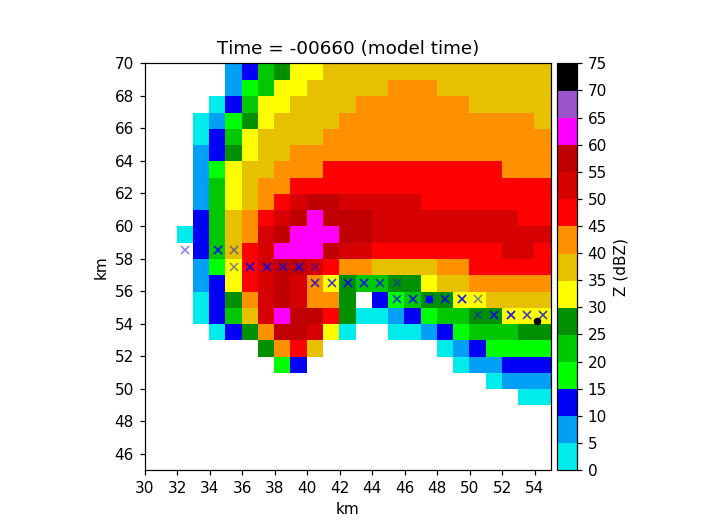

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  54100.0 54180.0


<IPython.core.display.Javascript object>


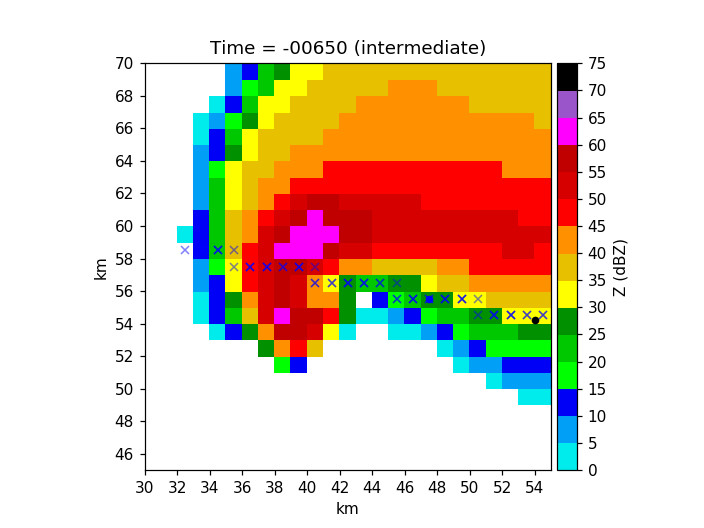

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  54000.0 54200.0


<IPython.core.display.Javascript object>


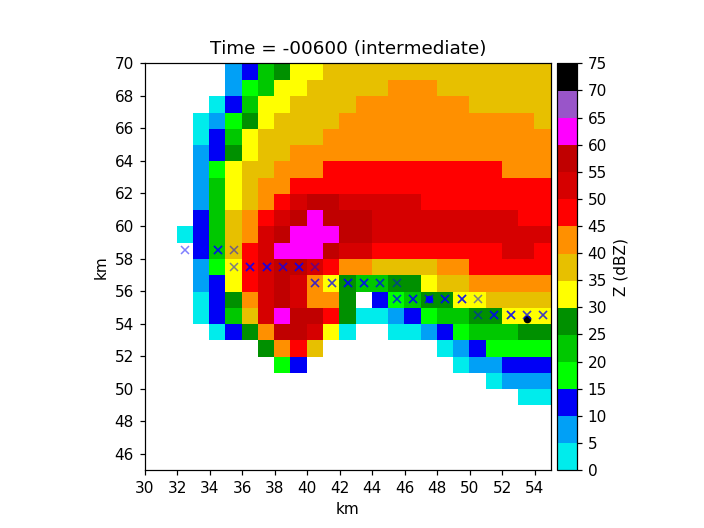

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  53500.0 54300.0


<IPython.core.display.Javascript object>


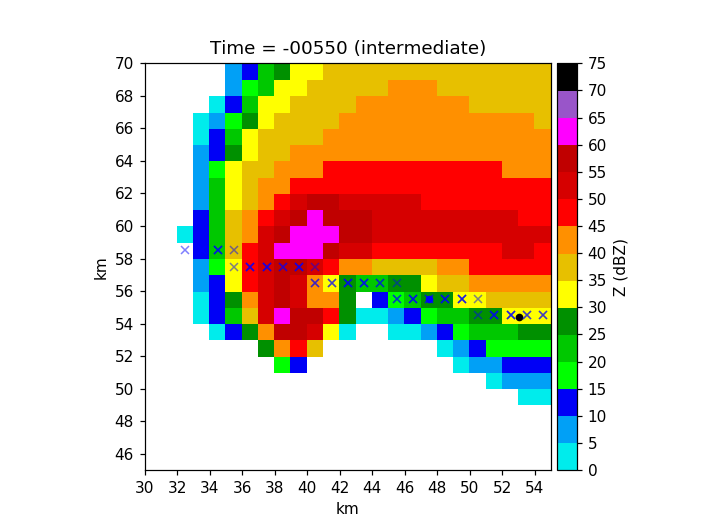

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  53000.0 54400.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


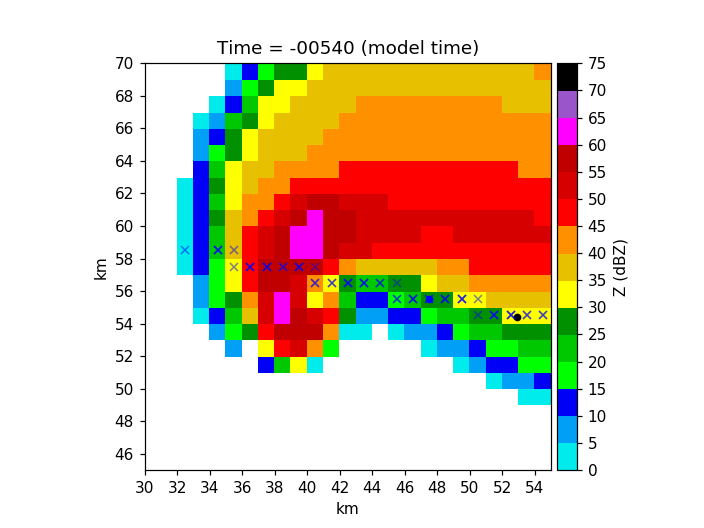

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  52900.0 54420.0


<IPython.core.display.Javascript object>


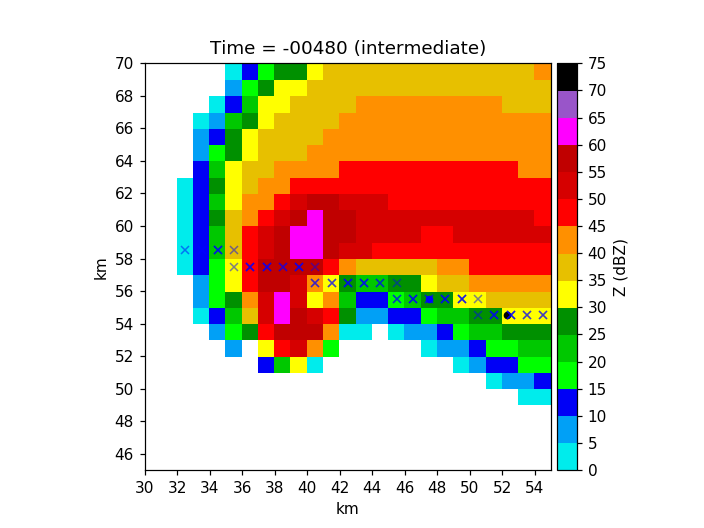

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  52300.0 54540.0


<IPython.core.display.Javascript object>


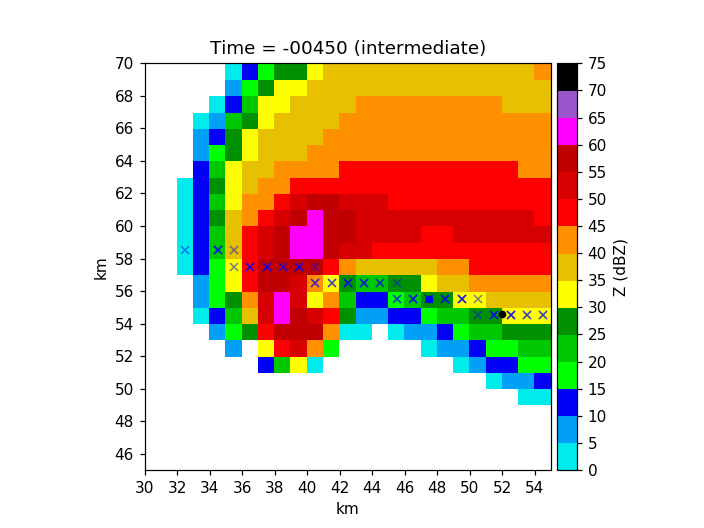

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  52000.0 54600.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


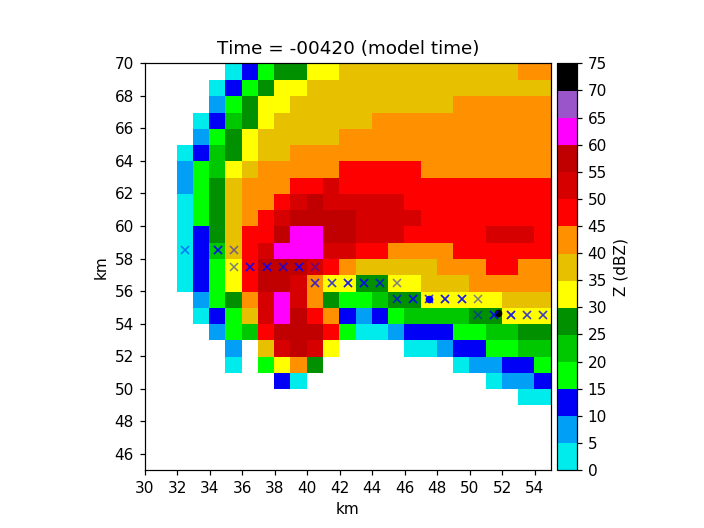

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  51700.0 54660.0


<IPython.core.display.Javascript object>


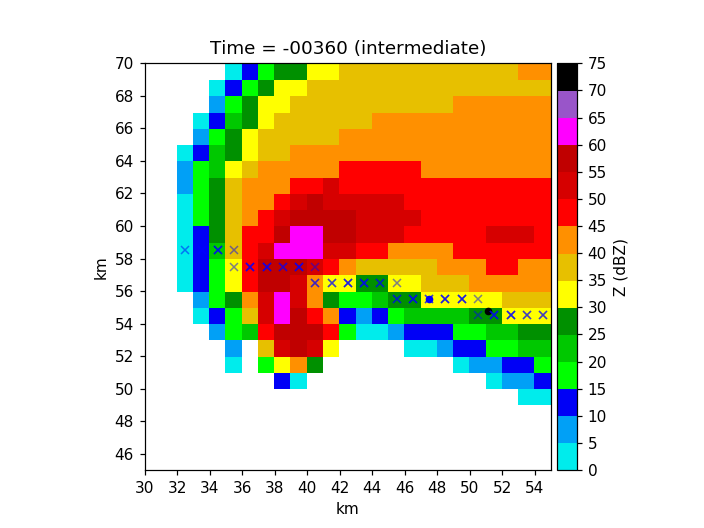

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  51100.0 54780.0


<IPython.core.display.Javascript object>


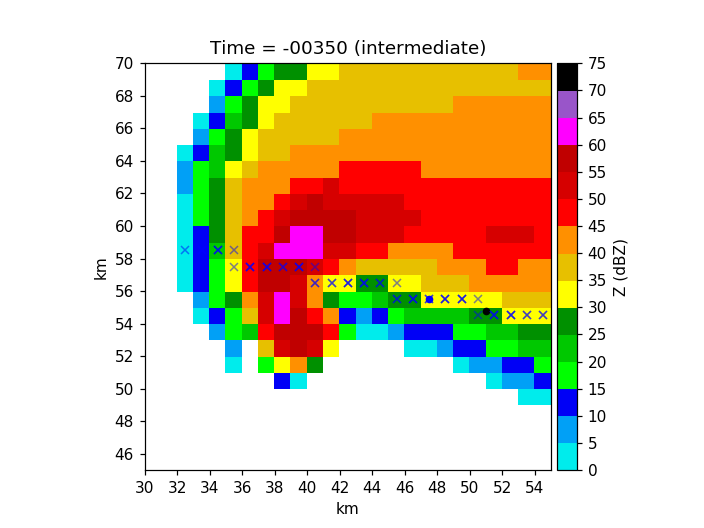

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  51000.0 54800.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


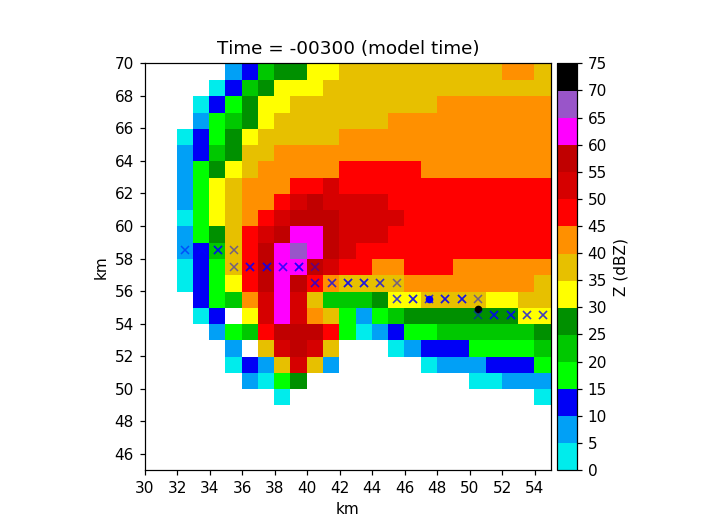

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  50500.0 54900.0


<IPython.core.display.Javascript object>


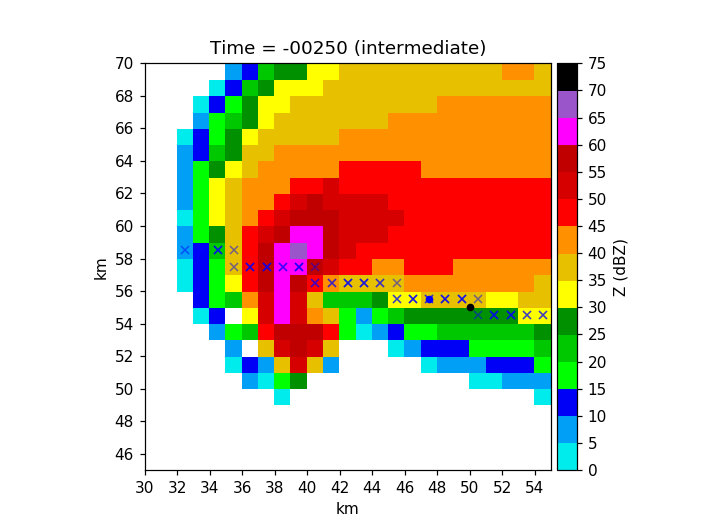

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  50000.0 55000.0


<IPython.core.display.Javascript object>


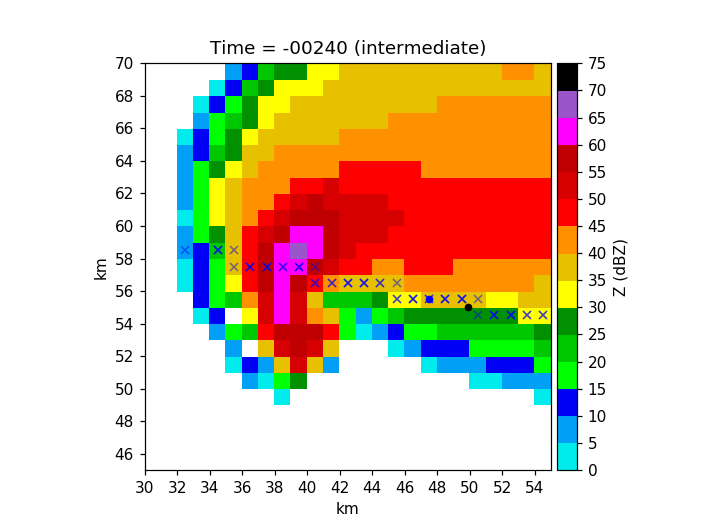

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  49900.0 55020.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


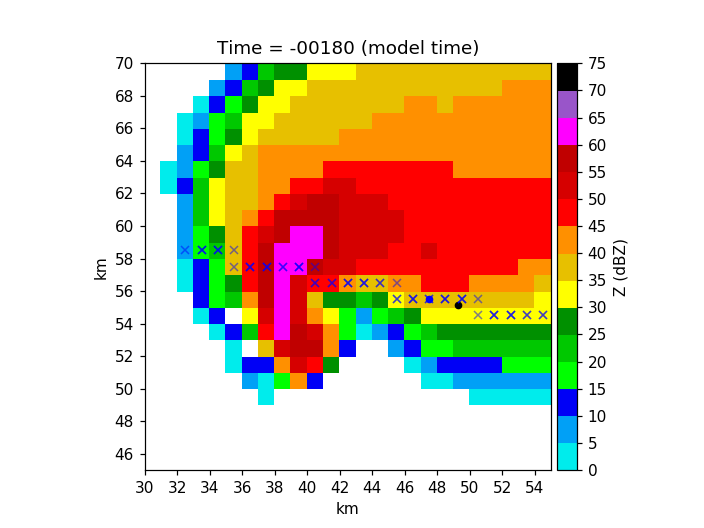

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  49300.0 55140.0


<IPython.core.display.Javascript object>


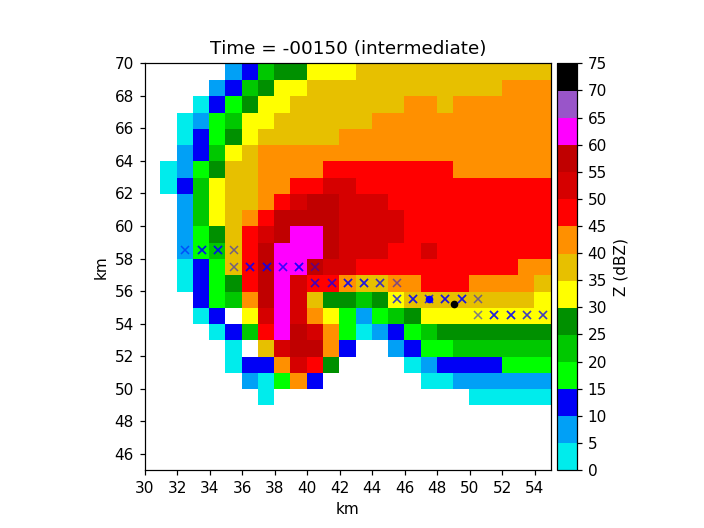

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  49000.0 55200.0


<IPython.core.display.Javascript object>


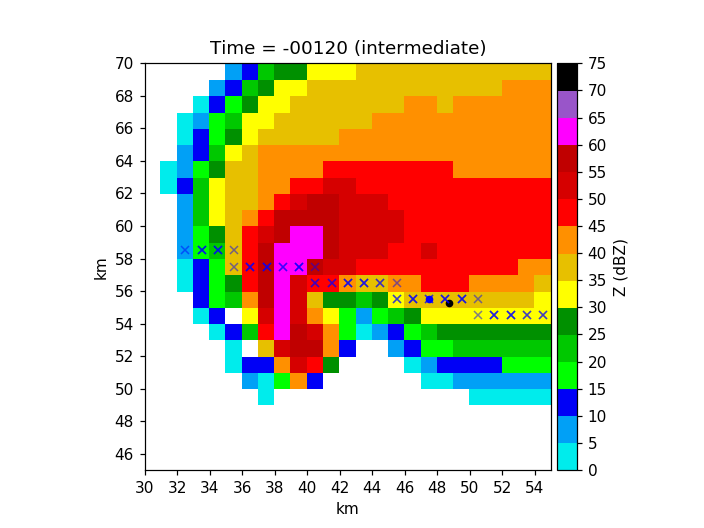

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  48700.0 55260.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


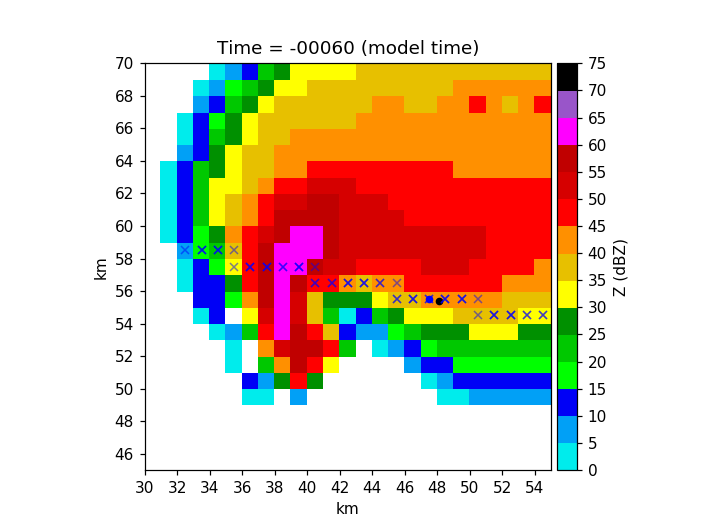

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  48100.0 55380.0


<IPython.core.display.Javascript object>


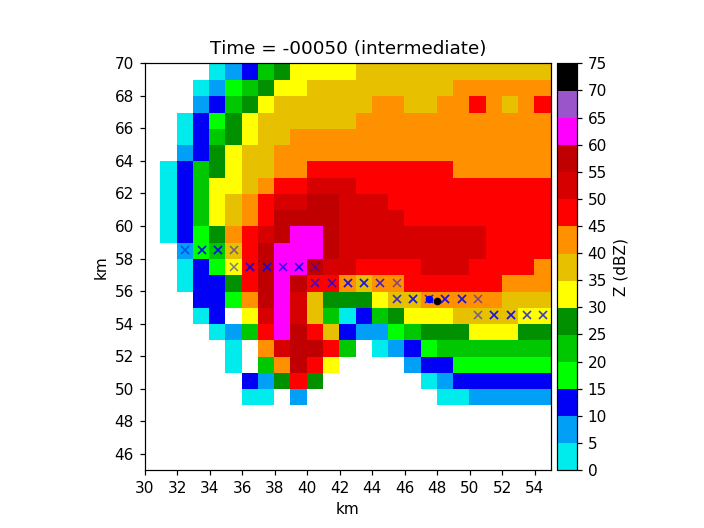

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  48000.0 55400.0


<IPython.core.display.Javascript object>


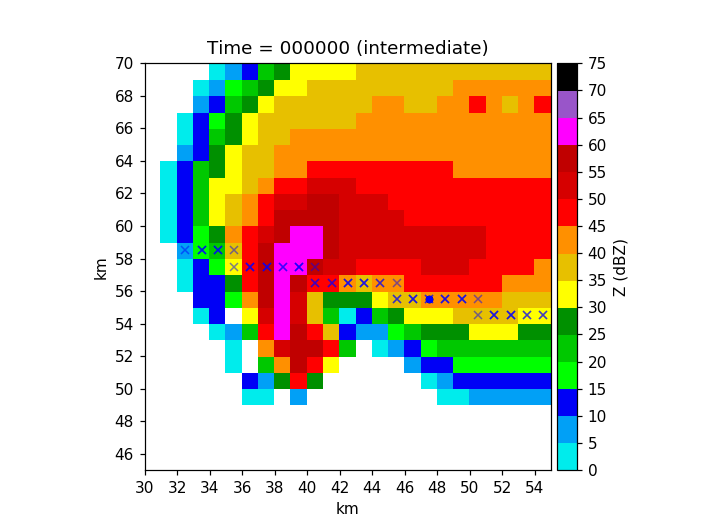

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  47500.0 55500.0


<IPython.core.display.Javascript object>


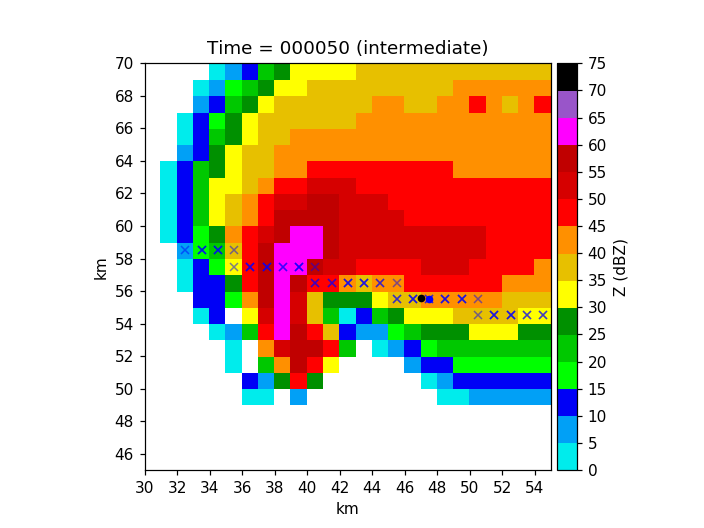

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  47000.0 55600.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


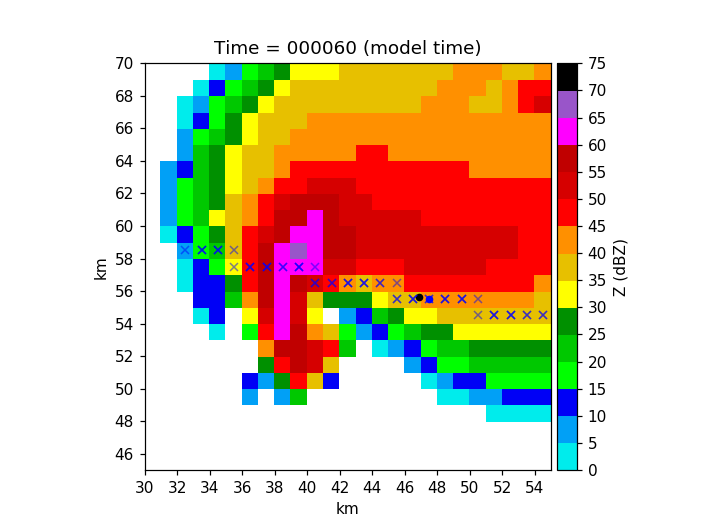

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  46900.0 55620.0


<IPython.core.display.Javascript object>


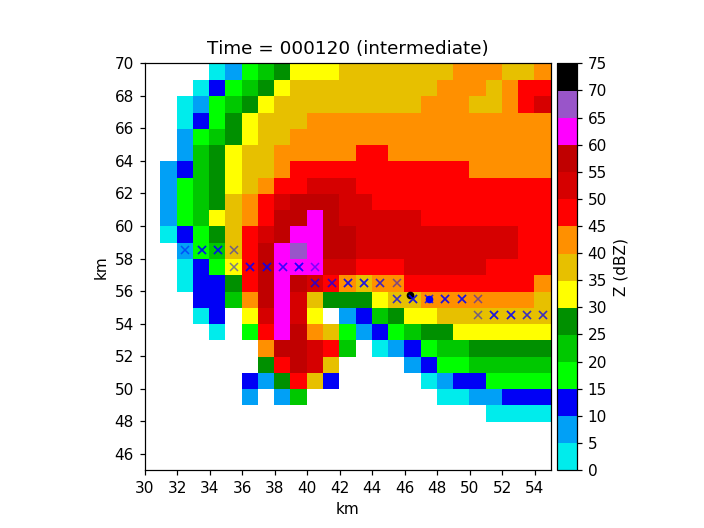

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  46300.0 55740.0


<IPython.core.display.Javascript object>


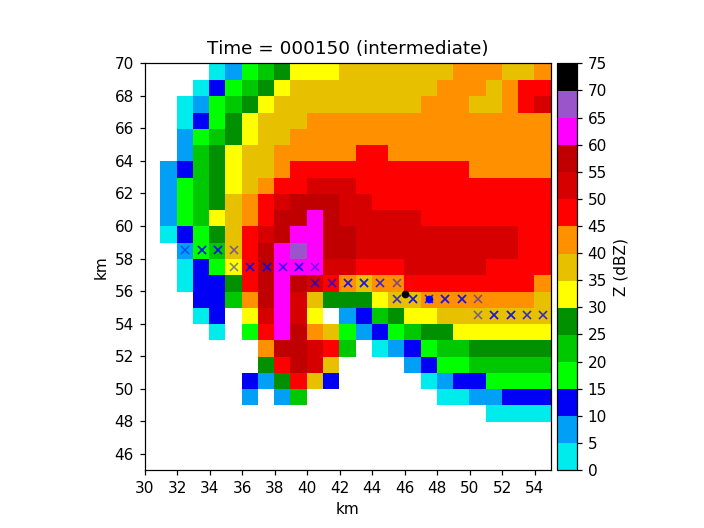

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  46000.0 55800.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


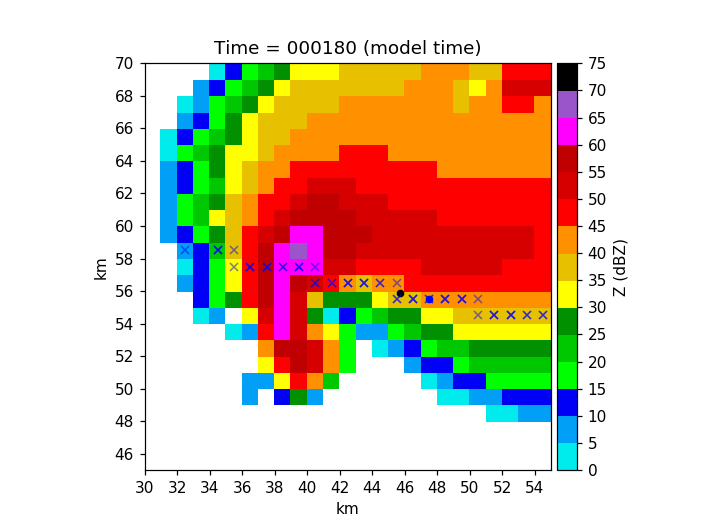

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  45700.0 55860.0


<IPython.core.display.Javascript object>


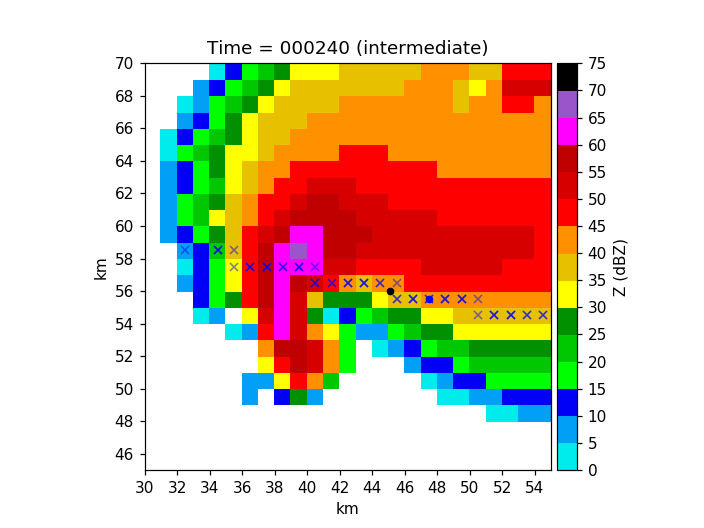

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  45100.0 55980.0


<IPython.core.display.Javascript object>


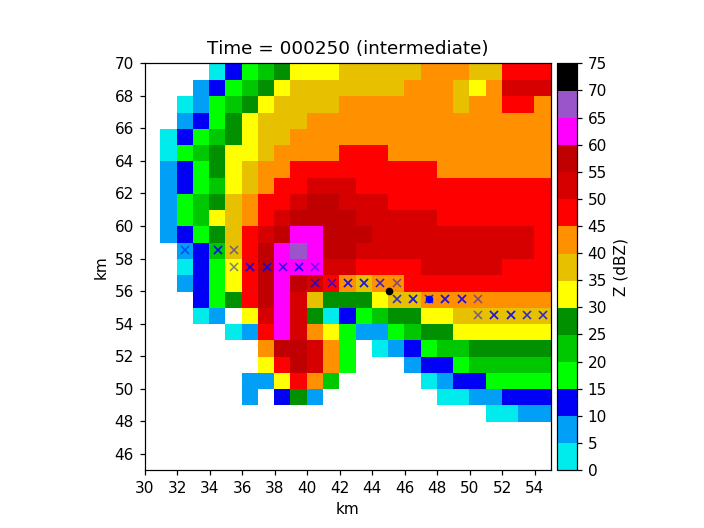

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  45000.0 56000.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


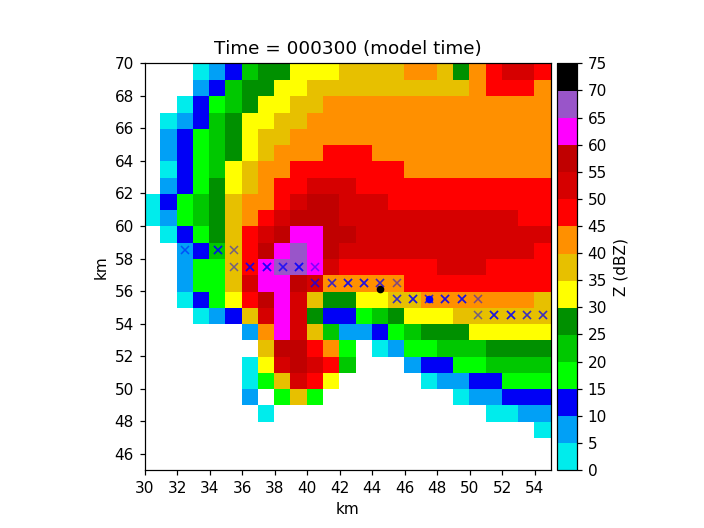

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  44500.0 56100.0


<IPython.core.display.Javascript object>


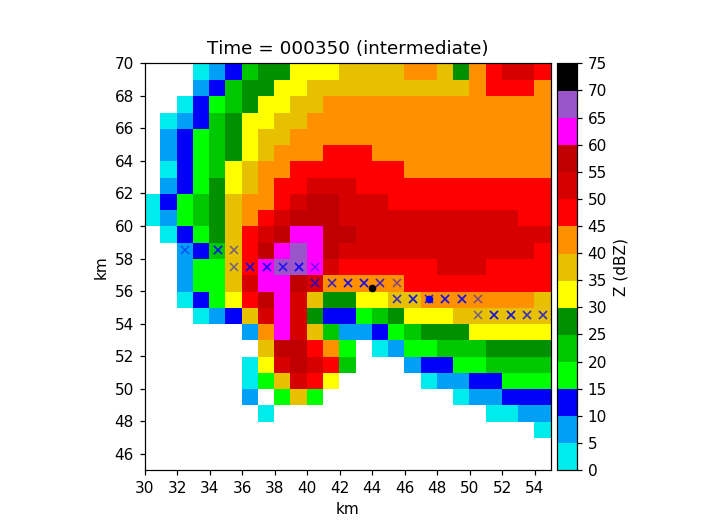

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  44000.0 56200.0


<IPython.core.display.Javascript object>


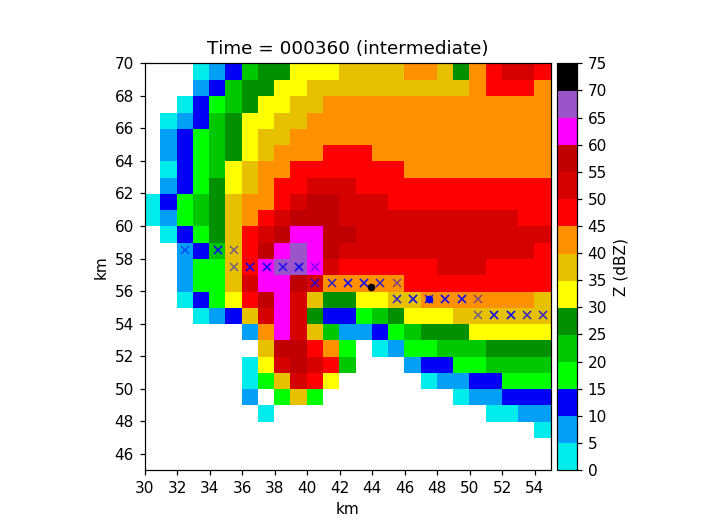

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  43900.0 56220.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


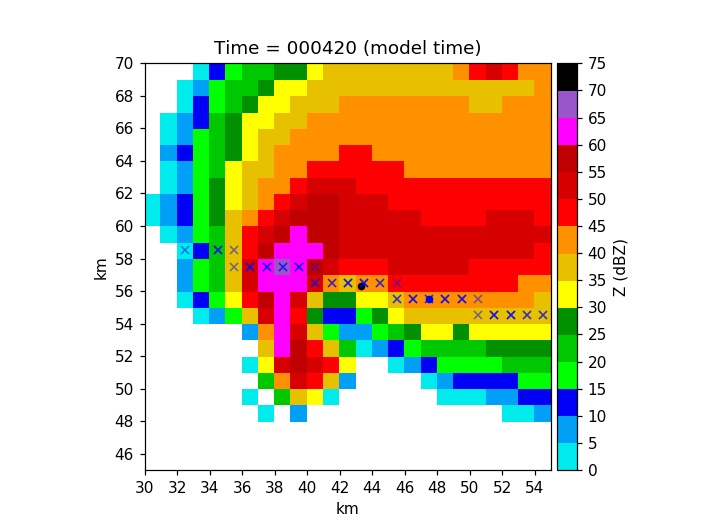

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  43300.0 56340.0


<IPython.core.display.Javascript object>


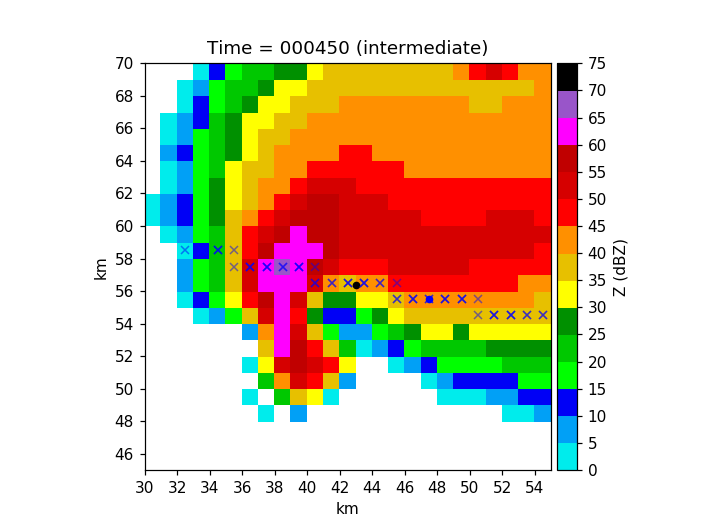

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  43000.0 56400.0


<IPython.core.display.Javascript object>


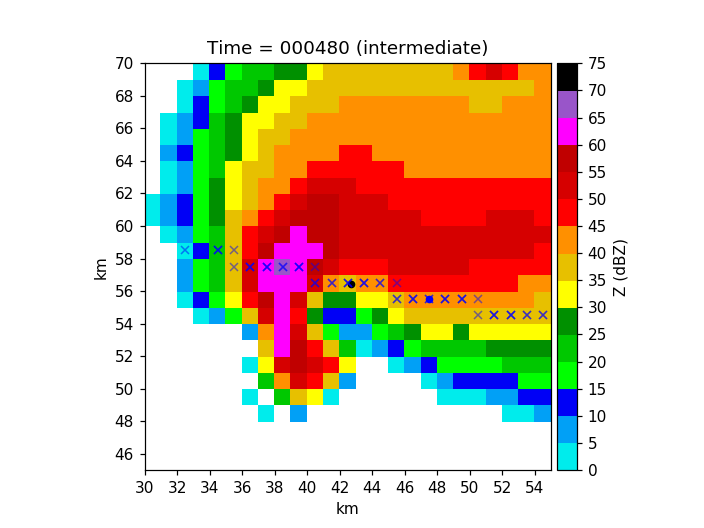

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  42700.0 56460.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


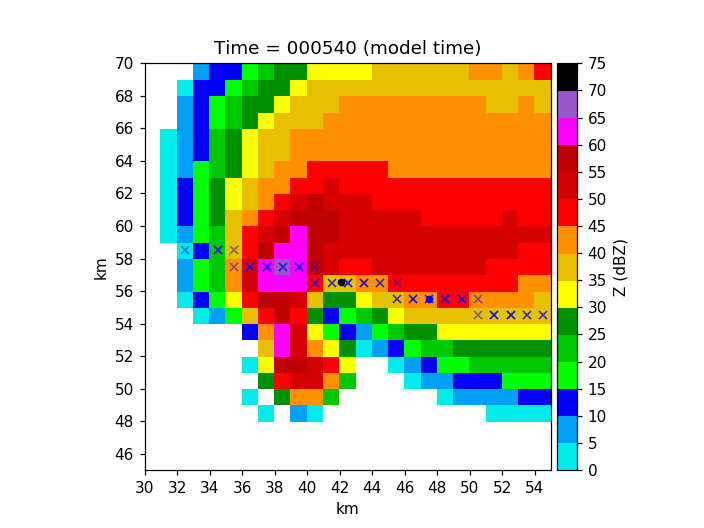

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  42100.0 56580.0


<IPython.core.display.Javascript object>


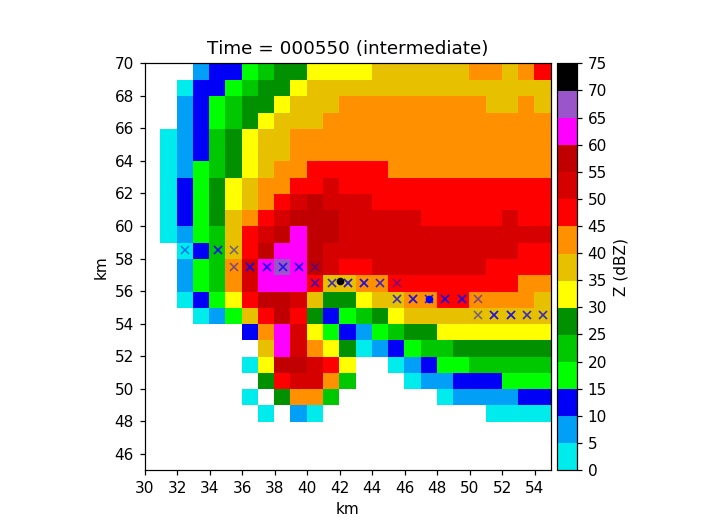

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  42000.0 56600.0


<IPython.core.display.Javascript object>


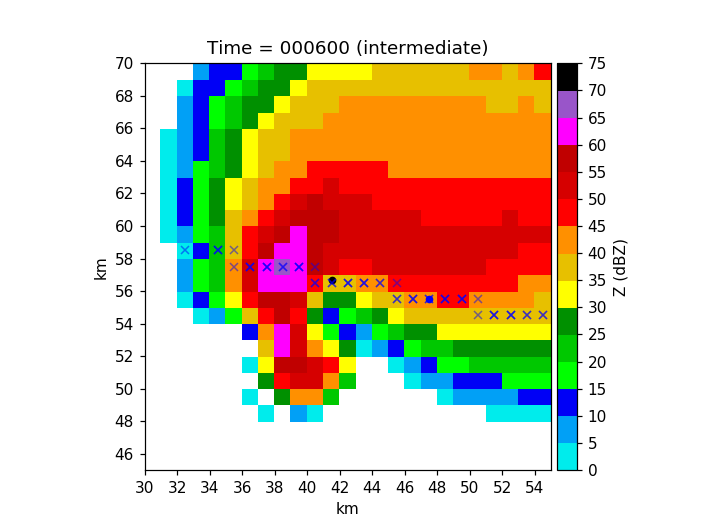

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  41500.0 56700.0


<IPython.core.display.Javascript object>


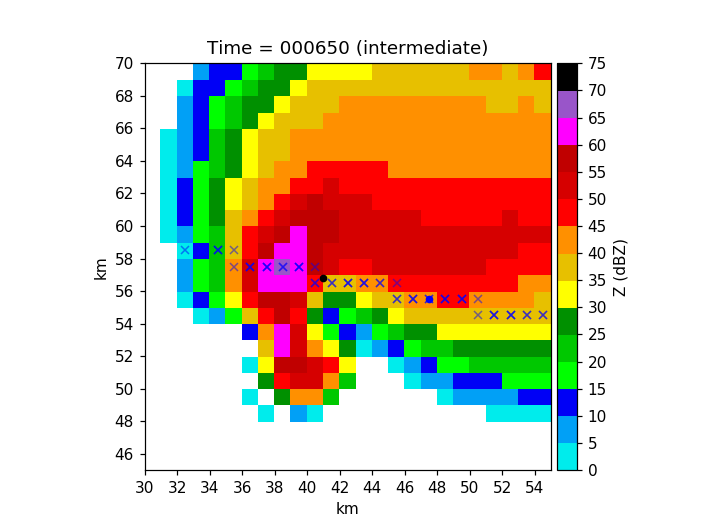

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  41000.0 56800.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


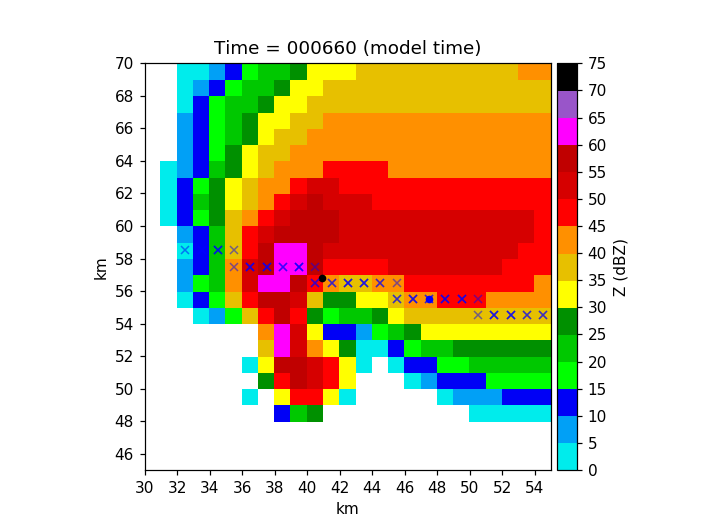

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  40900.0 56820.0


<IPython.core.display.Javascript object>


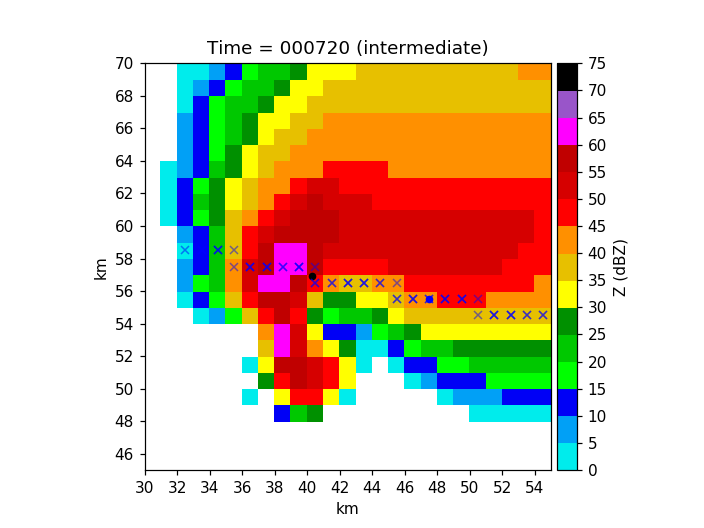

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  40300.0 56940.0


<IPython.core.display.Javascript object>


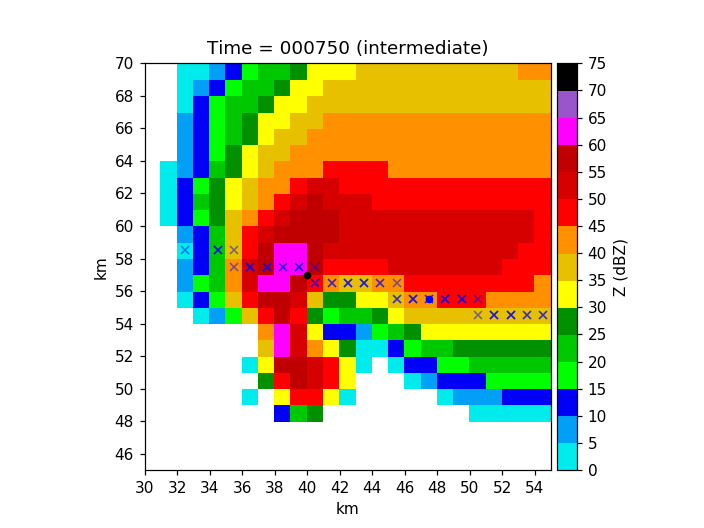

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  40000.0 57000.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


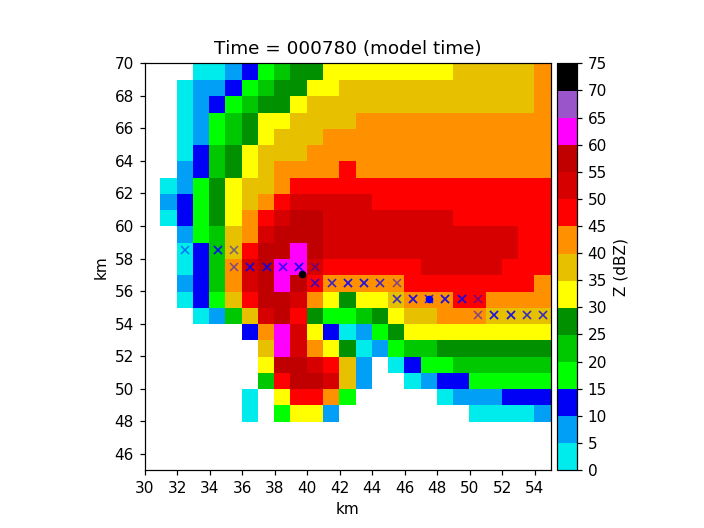

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  39700.0 57060.0


<IPython.core.display.Javascript object>


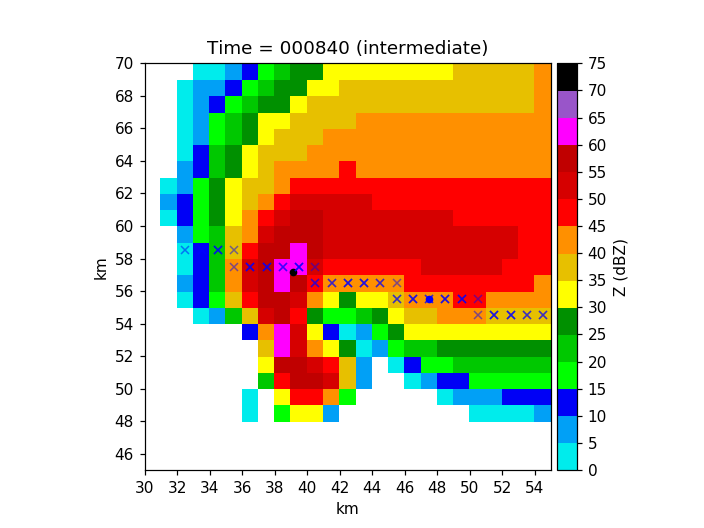

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  39100.0 57180.0


<IPython.core.display.Javascript object>


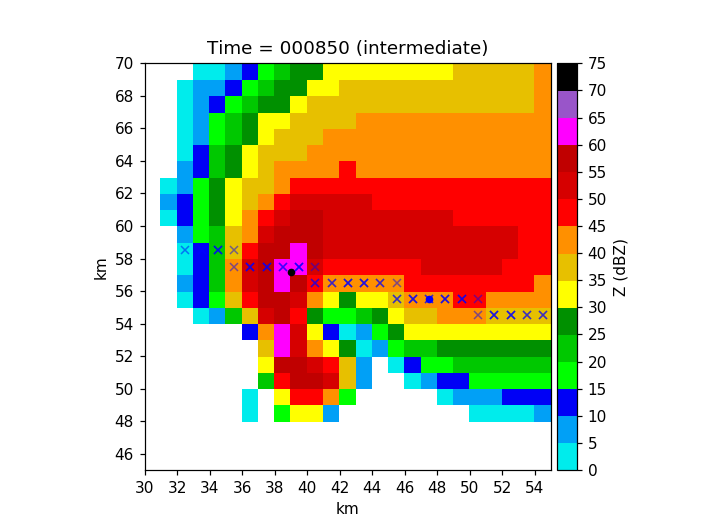

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  39000.0 57200.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


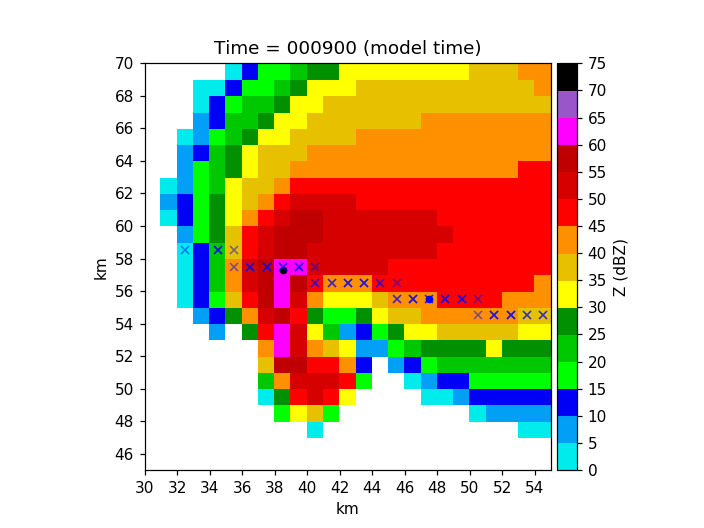

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  38500.0 57300.0


<IPython.core.display.Javascript object>


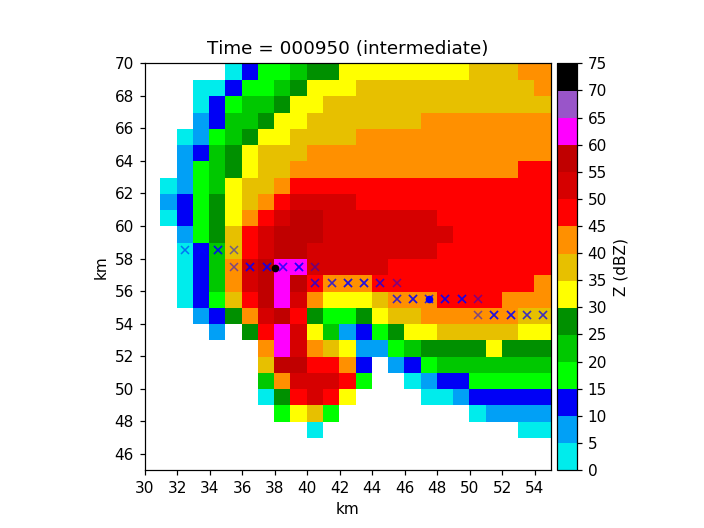

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  38000.0 57400.0


<IPython.core.display.Javascript object>


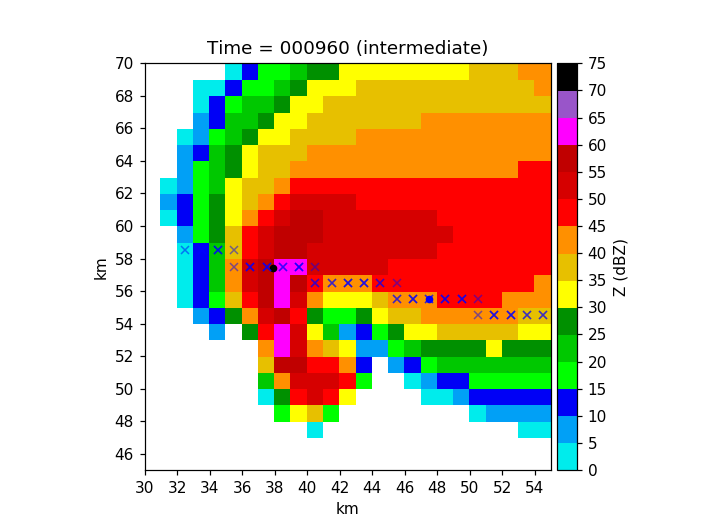

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  37900.0 57420.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


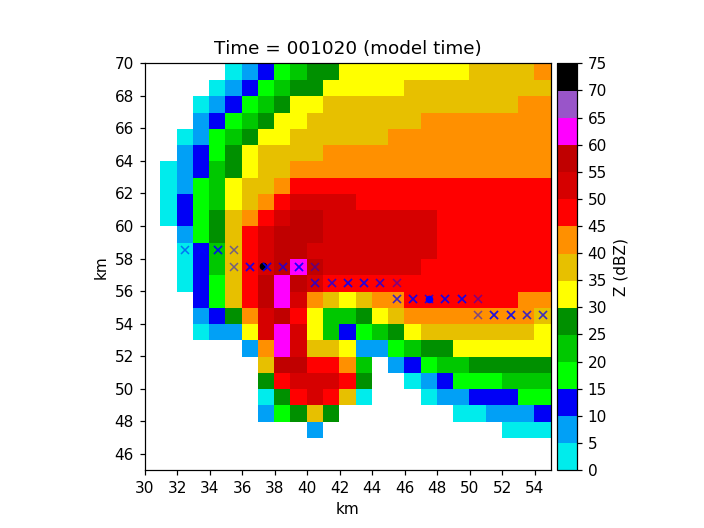

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  37300.0 57540.0


<IPython.core.display.Javascript object>


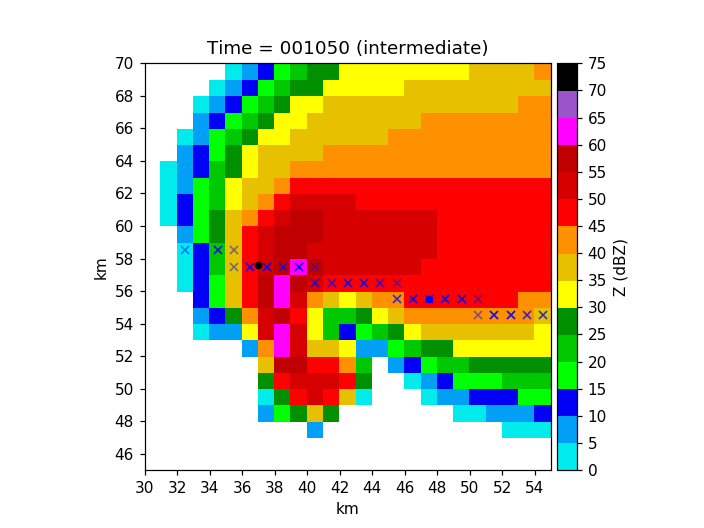

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  37000.0 57600.0


<IPython.core.display.Javascript object>


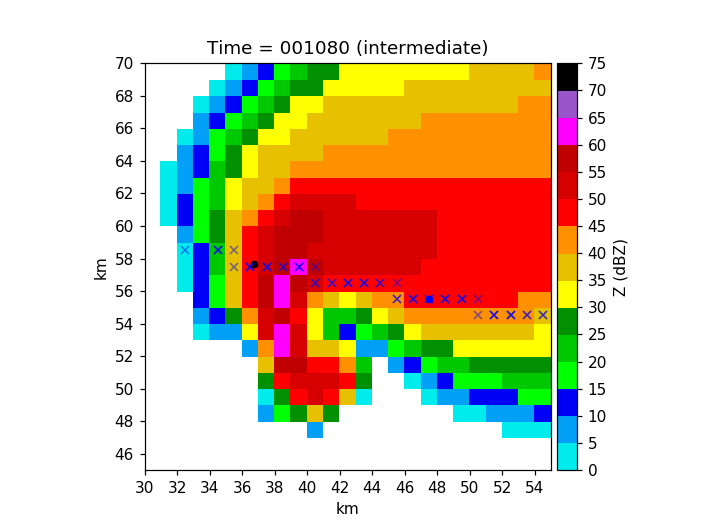

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  36700.0 57660.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


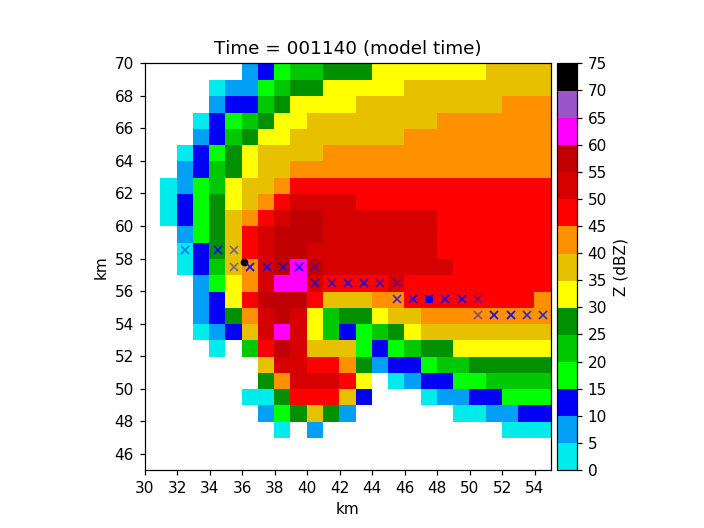

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  36100.0 57780.0


<IPython.core.display.Javascript object>


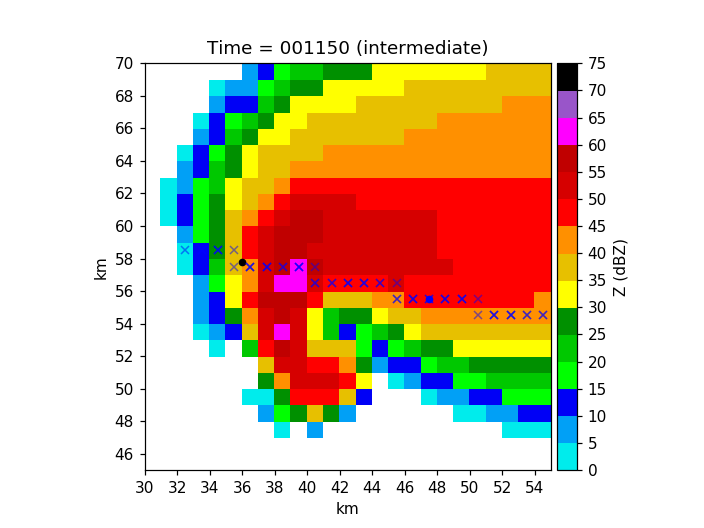

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  36000.0 57800.0


<IPython.core.display.Javascript object>


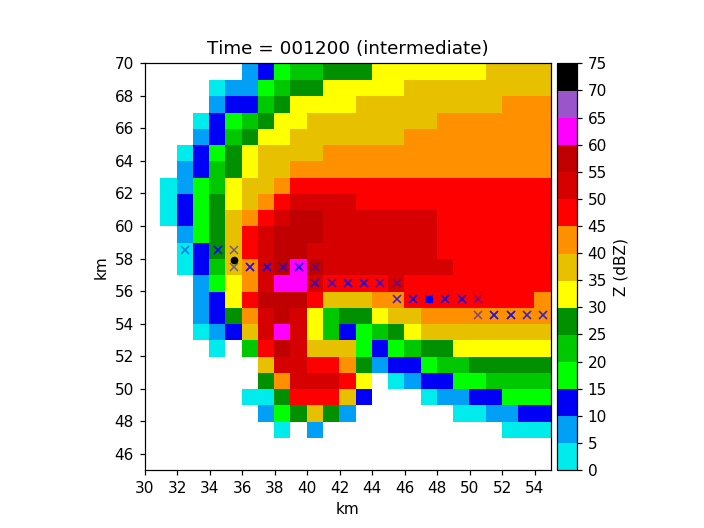

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  35500.0 57900.0


<IPython.core.display.Javascript object>


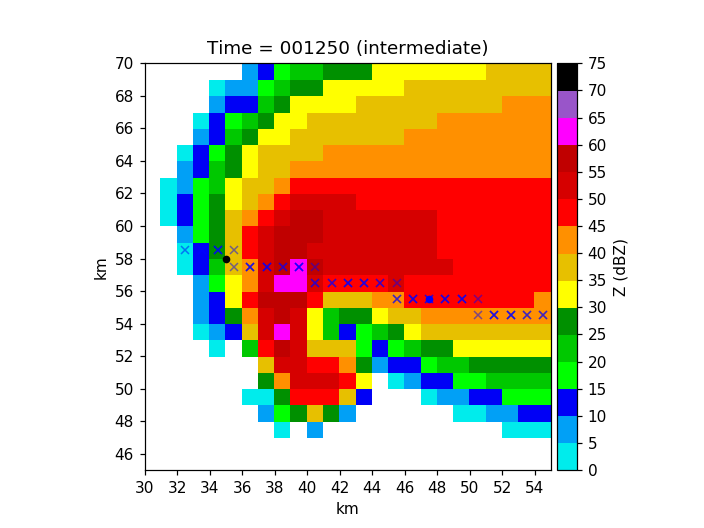

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  35000.0 58000.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


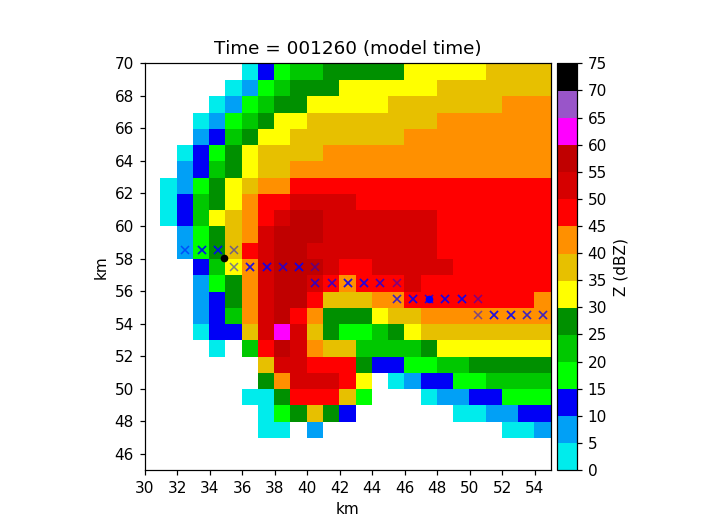

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  34900.0 58020.0


<IPython.core.display.Javascript object>


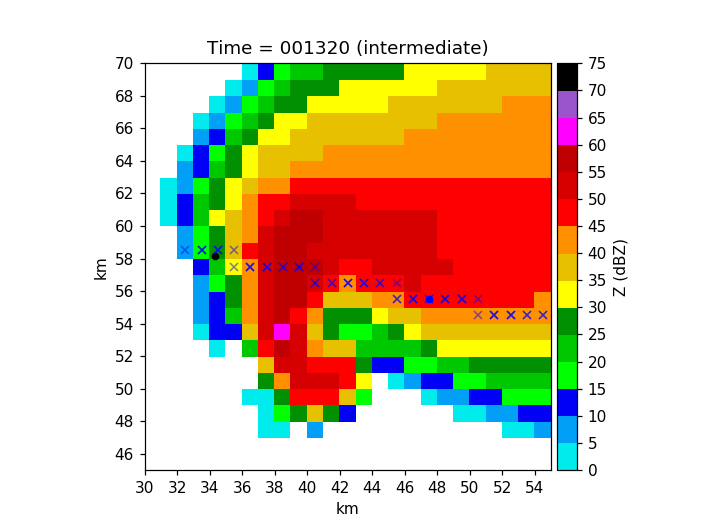

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  34300.0 58140.0


<IPython.core.display.Javascript object>


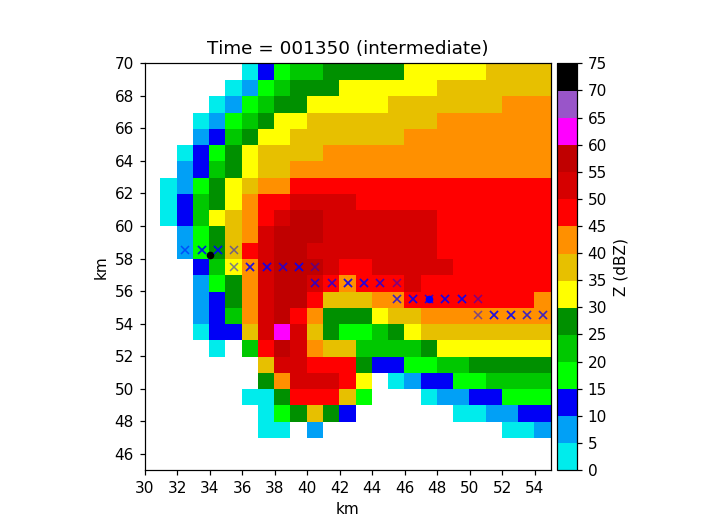

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  34000.0 58200.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


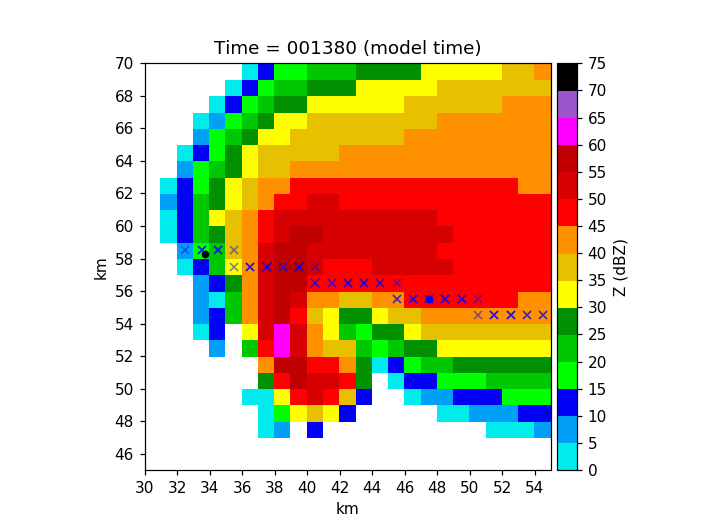

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  33700.0 58260.0


<IPython.core.display.Javascript object>


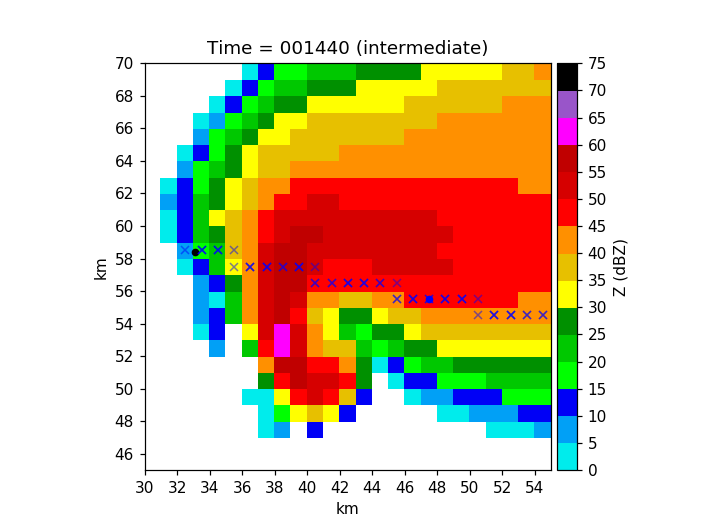

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  33100.0 58380.0


<IPython.core.display.Javascript object>


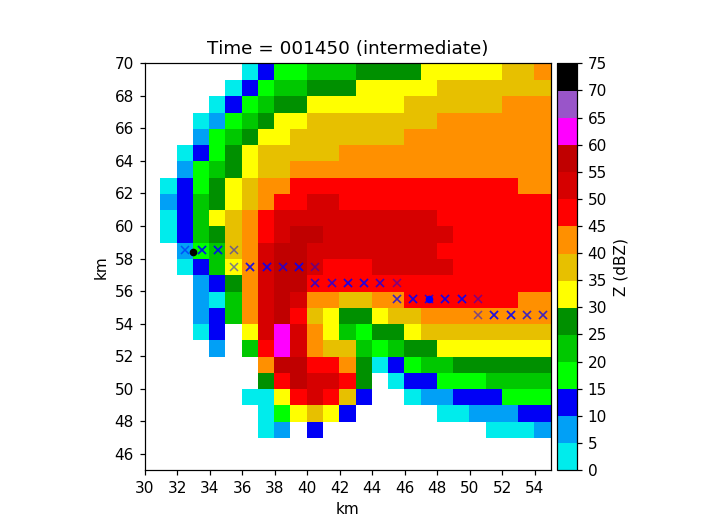

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  33000.0 58400.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


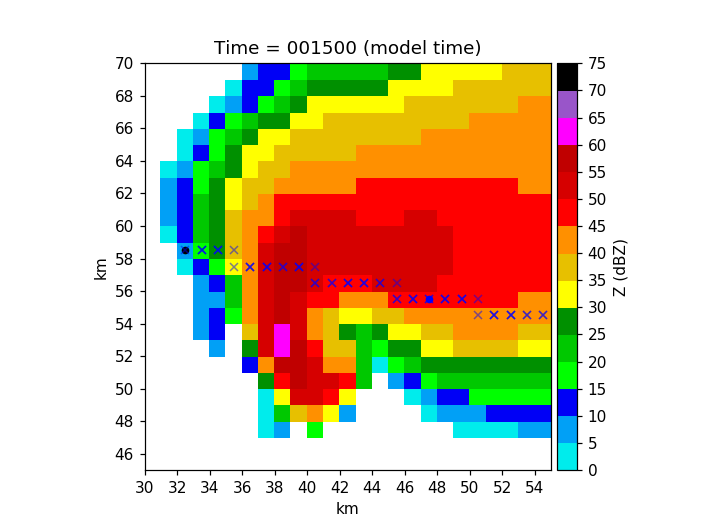

[30000.0, 55000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  32500.0 58500.0


In [107]:
# Ok, we are going to try to use the shapely library to figure out the intersections of the disdrometer "path"
# through the horizontally moving grid with the grid lines. We also want to allow for time to pass discretely
# between model history dumps. So, we have a 3D grid that the disdrometer
# moves through: 2D in space (x and y), and 1D in time. Thus, we first need to construct a collection of planes
# that represent the 3D grid boundaries.
# EDIT: for now just testing for 2D case
# Assumes a regular grid for now
# Based on https://stackoverflow.com/questions/45200428/how-to-find-intersection-of-a-line-with-a-mesh/45203700
from shapely.geometry import MultiLineString, LineString
from matplotlib.collections import LineCollection

plot_locations = True

xe1d = xe[0, 0, :]
ye1d = ye[0, :, 0]

xcplot = xc[0, :, :]
ycplot = yc[0, :, :]
xeplot = xe[0, :, :]
yeplot = ye[0, :, :]
xcorplot, ycorplot = pm.computecorners(xeplot, yeplot)

lines=[]
for x in xe1d:
    lines.append(((x, ye1d[0]), (x, ye1d[-1])))

for y in ye1d:
    lines.append(((xe1d[0], y), (xe1d[-1], y)))
    
grid = MultiLineString(lines)

# Reference time
reference_time = 9300.
# Location of fixed disdrometer at the reference time (m)
dis_x = 47500.
dis_y = 55500.
# Model times relative to reference time
model_times_rel = np.array(model_times - reference_time)
print "model_times_rel = ", model_times_rel
if model_times_rel.size == 1:
    fixed_time = True
# Movement of grid (m/s)
umove = 10.0
vmove = -2.0
# Sampling interval of the virtual disdrometer
sampling_interval = 60.
# Seconds before reference time to start the sampling
sampling_start = -600.
# Seconds after the reference time to stop the sampling
sampling_stop = 1500. 

# Calculate the range of times and the x and y locations at the end of each sampling window of the virtual disdrometer
sampling_times = np.arange(sampling_start, sampling_stop+sampling_interval, sampling_interval)
print "sampling_times = ", sampling_times
# Combine the sampling times and model times into a single array
combined_times = np.concatenate((sampling_times, model_times_rel))
combined_times = np.unique(combined_times)
print "combined_times = ", combined_times
sample_xlocs = dis_x - umove*sampling_times
sample_ylocs = dis_y - vmove*sampling_times
dis_xlocs = dis_x - umove*combined_times
dis_ylocs = dis_y - vmove*combined_times
print "dis_xlocs = ", dis_xlocs
print "dis_ylocs = ", dis_ylocs

line = LineString(np.c_[dis_xlocs, dis_ylocs])

# fig = plt.figure(figsize=(8,2))
# ax = fig.add_subplot(111)

all_times = []
xlocs = []
ylocs = []
ilocs = []
jlocs = []

for i, segment in enumerate(line.difference(grid)):
    x, y = segment.xy
#     print "i = ", i
#     print "x = ", np.array(x)
#     print "y = ", np.array(y)
#     plt.plot(x, y)
#     plt.text(np.mean(x), np.mean(y), str(i))
    
    # compute times of each crossing (relative to reference time)
    t = (dis_x - np.array(x))/umove
#     print "t = ", t
    xlocs = xlocs + list(x)
    ylocs = ylocs + list(y)
    all_times = all_times + list(t)

# lc = LineCollection(lines, color="gray", lw=1, alpha=0.5)
# ax.add_collection(lc)
# ax.set_aspect('equal')

print "xlocs = ", xlocs
print "ylocs = ", ylocs
print "all_times = ", all_times

xlocs = pd.unique(xlocs)
ylocs = pd.unique(ylocs)
all_times = pd.unique(all_times)

print "xlocs = ", xlocs
print "ylocs = ", ylocs
print "all_times = ", all_times

# Calculate the fractional i and j indices relative to grid edges corresponding to the x, y locations
ilocs = (xlocs-xeplot[0,0])/dx
jlocs = (ylocs-yeplot[0,0])/dy
print "ilocs = ", ilocs
print "jlocs = ", jlocs
# Calculate the fractional time indices corresponding to each point
if not fixed_time:
    tlocs = (all_times-model_times_rel[0])/model_dt
    tlocs = np.where(tlocs < 0.0, 0.0, tlocs)
    print "tlocs = ", tlocs
# Find the indices of the edges of the grid boxes that the disdrometer traverses during the sampling time
igllocs = ilocs.astype(int)
jgllocs = jlocs.astype(int)
print "igllocs = ", igllocs
print "jgllocs = ", jgllocs
# The -1 below is because we want to identify the right edges with the next lowest grid centers
igrlocs = np.ceil(ilocs).astype(int)-1
jgrlocs = np.ceil(jlocs).astype(int)-1
print "igrlocs = ", igrlocs
print "jgrlocs = ", jgrlocs
if not fixed_time:
    tgblocs = tlocs.astype(int)
    print "tgblocs = ", tgblocs

# The grid edge indices we want to use for calculating the sampling depend on the grid motion
if umove > 0 and vmove > 0:
    locs = [jgrlocs, igrlocs]
elif umove < 0 and vmove > 0:
    locs = [jgrlocs, igllocs]
elif umove < 0 and vmove < 0:
    locs = [jgllocs, igllocs]
else:
    locs = [jgllocs, igrlocs]

# For plotting we want the indices of the west and south edges
plocs = [jgllocs, igllocs]
    
dp_data_plot_list = []
Zmodplot_list = []
time = None
for t, tloc in enumerate(tgblocs):
    if(model_times[tloc] != time):
        time = model_times[tloc]
        timestring = dh.setTime(time)
        dp_data, consts = dh.loadMicrophysics()
        # Extract the lowest model level and store in dp_data_2D
        dp_data_2D = {}
        for key, dat in dp_data.iteritems():
            dp_data_2D[key] = dat[:,:,0]
        dp_data_plot = {}
        for key, dat in dp_data_2D.iteritems():
            dp_data_plot[key] = dat.swapaxes(0, 1).squeeze()
        dp_data_plot_list.append(dp_data_plot)

        Zmod = dh.loadModelReflectivity()
        Zmodplot = Zmod[:, :, 0].T
        Zmodplot_list.append(Zmodplot)
    else:
        dp_data_plot = dp_data_plot_list[-1]
        dp_data_plot_list.append(dp_data_plot)
        Zmodplot = Zmodplot_list[-1]
        Zmodplot_list.append(Zmodplot)
    
    # qrplot = dp_data_2D['qr'].T*1000.
    
    if plot_locations:
        fig = None
        ax = None
        ptype = 2
        xlim = [30000.0, 55000.0]
        ylim = [45000.0, 70000.0]
        clevels = np.arange(0., 85., 5.)
        norm, cmap = ctables.registry.get_with_steps('NWSReflectivity', 0., 5.)
        clabel = 'Z (dBZ)'
        cformat = None
        ovrmap = False
        gis_info = None
        numovr = 0
        axesticks = [2000., 2000.]

        fig, ax = pm.plotsingle(fig, ax, ptype, xcplot, ycplot, xcorplot, ycorplot, xlim, ylim, Zmodplot, clevels, cmap, norm,
                            clevels, clabel, cformat, ovrmap, gis_info, numovr, None, None, None, None, None,
                            axesticks)

        # Plot the locations of the disdrometer at each time in the sampling period
        #ax.plot(dis_xlocs, dis_ylocs, 'ko', ms=2)
        print "x, y = ", xlocs[t], ylocs[t]
        ax.plot(xlocs[t], ylocs[t], 'ko', ms=4)
        ax.plot(dis_x, dis_y, 'bo', ms=4)
        ax.plot(xcplot[plocs], ycplot[plocs], 'bx', ms=5, alpha=0.5)

        if(all_times[t] == model_times_rel[tloc]):
            titlestring = 'Time = %06d' % all_times[t] + ' (model time)'
        else:
            titlestring = 'Time = %06d' % all_times[t] + ' (intermediate)'

        ax.set_title(titlestring)
    


In [108]:
sample_indices = np.searchsorted(all_times, sampling_times)
print "sampling_times = ", sampling_times
print "all_times = ", all_times
print "sample_indices = ", sample_indices

# dt = np.zeros_like(all_times)
# dt[0] = 0.0
dt = all_times[1:]-all_times[:-1]
print "dt = ", dt

sample_indices = np.searchsorted(all_times, sampling_times)
print np.size(sample_indices), np.size(sampling_times)
t = 0
for s, sample_index in enumerate(sample_indices[:-1]):
    sample_index_end = sample_indices[s+1]
#     print "s, sample_index, sample_index_end = ", s, sample_index, sample_index_end
#     current_sample_indices = slice(sample_index, sample_index_end, None)
#     print "sample time (beginning) = ", sampling_times[s]
#     print "sample time (end) = ", sampling_times[s+1]
#     print "delta_t's for this interval = ", dt[current_sample_indices]

print "locs = ", locs 
print "xcplot[locs] = ", xcplot[locs]

print "locs (t=0) = ", (jgllocs[0], igllocs[0])
print "xcplot[locs] (t=0) = ",xcplot[(jgllocs[0], igllocs[0])]

sampling_times =  [-600. -540. -480. -420. -360. -300. -240. -180. -120.  -60.    0.   60.
  120.  180.  240.  300.  360.  420.  480.  540.  600.  660.  720.  780.
  840.  900.  960. 1020. 1080. 1140. 1200. 1260. 1320. 1380. 1440. 1500.]
all_times =  [-660. -650. -600. -550. -540. -480. -450. -420. -360. -350. -300. -250.
 -240. -180. -150. -120.  -60.  -50.    0.   50.   60.  120.  150.  180.
  240.  250.  300.  350.  360.  420.  450.  480.  540.  550.  600.  650.
  660.  720.  750.  780.  840.  850.  900.  950.  960. 1020. 1050. 1080.
 1140. 1150. 1200. 1250. 1260. 1320. 1350. 1380. 1440. 1450. 1500.]
sample_indices =  [ 2  4  5  7  8 10 12 13 15 16 18 20 21 23 24 26 28 29 31 32 34 36 37 39
 40 42 44 45 47 48 50 52 53 55 56 58]
dt =  [10. 50. 50. 10. 60. 30. 30. 60. 10. 50. 50. 10. 60. 30. 30. 60. 10. 50.
 50. 10. 60. 30. 30. 60. 10. 50. 50. 10. 60. 30. 30. 60. 10. 50. 50. 10.
 60. 30. 30. 60. 10. 50. 50. 10. 60. 30. 30. 60. 10. 50. 50. 10. 60. 30.
 30. 60. 10. 50.]
36 36
locs =  [ar

(36,)


<IPython.core.display.Javascript object>


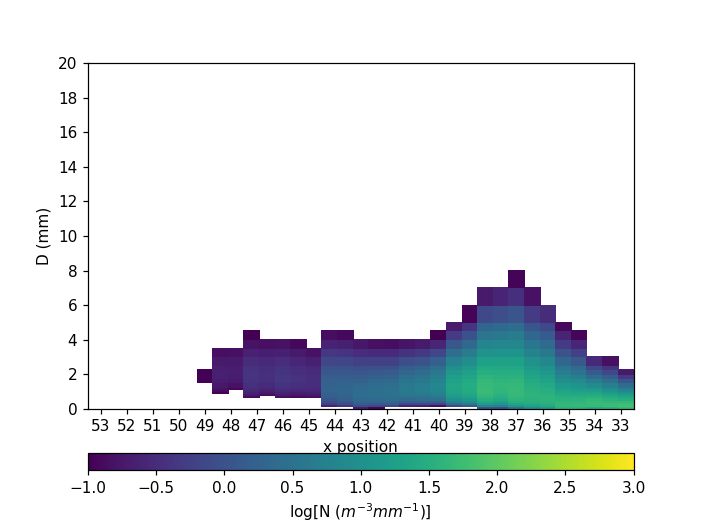

In [114]:
# Now find the values of the various DSD parameters at each disdrometer location
# We can use map_coordinates since we are dealing with a rectilinear non-stretched grid in the horizontal
# from scipy.ndimage import map_coordinates
# coords = np.array([dis_ilocs, dis_jlocs])
# # order=0 means nearest-neighbor interpolation
# dis_Zmod = map_coordinates(Zmodplot.T, coords, order=0)
# dis_rhoa = map_coordinates(dp_data_2D['rhoa'], coords, order=0)
# dis_qr = map_coordinates(dp_data_2D['qr'], coords, order=0)
# dis_ntr = map_coordinates(dp_data_2D['ntr'], coords, order=0)
# dis_alphar = map_coordinates(dp_data_2D['alphar'], coords, order=0)

# Loop through all the times and compute the binned model DSD for each

rhoa = []
qr = []
ntr = []
alphar = []
for t, dp_data_plot in enumerate(dp_data_plot_list):
    loc = (locs[0][t], locs[1][t])
#     print "loc = ", loc
    rhoa.append(dp_data_plot['rhoa'][loc])
    qr.append(dp_data_plot['qr'][loc])
    ntr.append(dp_data_plot['ntr'][loc])
    alphar.append(dp_data_plot['alphar'][loc])
    
rhoa =  np.array(rhoa)
qr = np.array(qr)
ntr = np.array(ntr)
alphar = np.array(alphar)

# print "rhoa = ", rhoa, rhoa.shape
# print "qr = ", qr
# print "ntr = ", ntr
# print "alphar = ", alphar

N0r, _ = dsd.cal_N0(rhoa, qr, ntr, cr, alphar)
lamdar = dsd.cal_lamda(rhoa, qr, ntr, cr, alphar)
Nc_bin_tmp = np.empty((np.size(N0r), np.size(D)))
Nc_bin = np.zeros((np.size(np.array(sampling_times)), np.size(D)))

for index, _ in np.ndenumerate(N0r):
    Nc_bin_tmp[index, :] = 1.e-3*N0r[index]*(D)**alphar[index]*np.exp(-lamdar[index]*(D))
Nc_bin_tmp = np.ma.masked_invalid(Nc_bin_tmp)

# Now loop through and "resample" the number concentrations as weighted averages 
# for the case that the disdrometer crosses a grid edge or the model DSD changes during the sampling interval.

# Special treatment for first sampling time. Just assume DSD valid at that time was constant for the previous 
# sampling interval

sample_indices = np.searchsorted(all_times, sampling_times)
print sample_indices.shape
Nc_bin[0, :] = Nc_bin_tmp[sample_indices[0], :]
for s, sample_index in enumerate(sample_indices[:-1]):
    sample_index_end = sample_indices[s+1]
    current_sample_indices = slice(sample_index, sample_index_end, None)
    
    Nc_bin[s+1, :] = np.sum(Nc_bin_tmp[current_sample_indices, :]*dt[current_sample_indices, None], axis = 0)/sampling_interval
#     print "s = ", s
#     print "sample time (beginning) = ", sampling_times[s]
#     print "sample time (end) = ", sampling_times[s+1]
    #print "Nc_bin_tmp = ", Nc_bin_tmp[current_sample_indices, :], dt[current_sample_indices]
    #print "Nc_bin = ", Nc_bin[s+1, :]
    
logNc_bin = np.log10(Nc_bin)
logNc_bin = np.ma.masked_where(logNc_bin <= -1.0,logNc_bin)

plotparamdicts = [{'type': 'pcolor', 'vlimits': (-1.0, 3.0), 'clabel': r'log[N ($m^{-3} mm^{-1}$)]'}]
xvals = [sample_xlocs/1000.]
yvals = [Dl*1000.]
zvals = [logNc_bin.T]
ax = pm.plotmeteogram(None, xvals, zvals, plotparamdicts, yvals=yvals)
axparamdicts = [{'majorxlocator': ticker.MultipleLocator(base=1.0), 
                 'majorylocator': ticker.MultipleLocator(base=2.0),
                 'axeslimits': [None, (0.0, 20.0)],
                 'axeslabels': ['x position', 'D (mm)']}]
axlist = pm.set_meteogram_axes([ax], axparamdicts)
for ax in axlist:
    ax.invert_xaxis()
plt.savefig('raw_modelDSD.png',dpi=300)

/Users/dawson29/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in log10


<IPython.core.display.Javascript object>


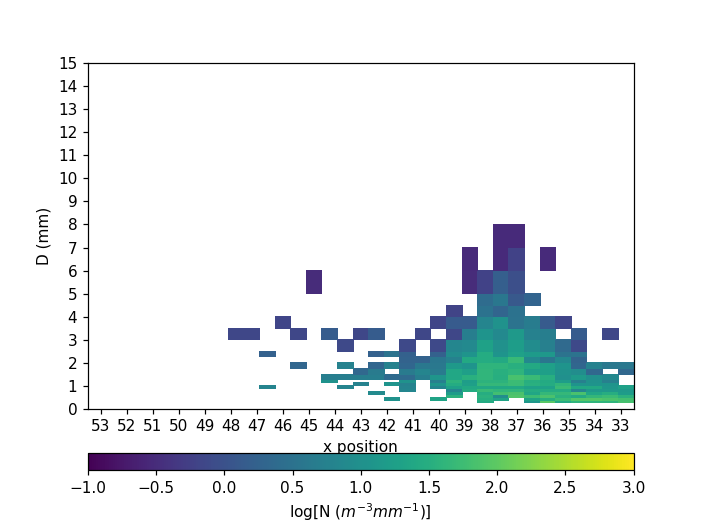

In [115]:
Nc_bin2 = np.empty((np.size(N0r), np.size(D[:Dmax_index+1])))
# Now plot the sampled distribution

Nc_bin_tmp2 = np.zeros((np.size(N0r), np.size(D[:Dmax_index+1])))
Nc_bin2 = np.zeros((np.size(np.array(sampling_times)), np.size(D[:Dmax_index+1])))


# Special treatment for first sampling time. Just assume DSD valid at that time was constant for the previous 
# sampling interval
sample_dict = sim.create_random_gamma_DSD(ntr[0], lamdar[0], 
                                          alphar[0], Vtr, sampling_length, 
                                          sampling_width, Dl, D, Dr, sampling_interval=sampling_interval,
                                          remove_margins=True, rhocorrect=True, rho=rhoa[0])
ND_sample = sample_dict['ND']
pcount_binned_sample = sample_dict['pcount_binned']
Nc_bin_tmp2[0, :] = 1.e-3*ND_sample
Nc_bin2[0, :] = Nc_bin_tmp2[0, :]

pcount_binned_samples = []
for index, _ in np.ndenumerate(N0r[:-1]):
    sample_dict = sim.create_random_gamma_DSD(ntr[index], lamdar[index], 
                                          alphar[index], Vtr, sampling_length, 
                                          sampling_width, Dl, D, Dr, sampling_interval=dt[index],
                                          remove_margins=True, rhocorrect=True, rho=rhoa[index])
    ND_sample = sample_dict['ND']
    pcount_binned_samples.append(sample_dict['pcount_binned'])
    Nc_bin_tmp2[index, :] = 1.e-3*ND_sample

pcount_binned_samples = np.array(pcount_binned_samples)
    
Nc_bin_tmp2 = np.ma.masked_invalid(Nc_bin_tmp2)

sampling_volumes_D = sim.calc_sampling_volumes_D(Vtr, Dr, Dmax, sampling_interval, sampling_area)
for s, sample_index in enumerate(sample_indices[:-1]):
    sample_index_end = sample_indices[s+1]
    current_sample_indices = slice(sample_index, sample_index_end, None)
    pcount_binned = np.sum(pcount_binned_samples[current_sample_indices], axis=0)
    Nc_bin2[s+1, :] = 1.e-3*sim.calc_ND(pcount_binned, sampling_volumes_D, Dr, Dl, Dmax)
#     Nc_bin2[s+1, :] = np.sum(Nc_bin_tmp2[current_sample_indices, :]*dt[current_sample_indices, None], axis = 0)/sampling_interval
#     print "s = ", s
#     print "sample time (beginning) = ", sampling_times[s]
#     print "sample time (end) = ", sampling_times[s+1]
#     print "dt[current_sample_indices] = ", dt[current_sample_indices]
#     print "Nc_bin_tmp = ", Nc_bin_tmp[current_sample_indices, :], dt[current_sample_indices]
#     print "Nc_bin = ", Nc_bin[s+1, :]

Nc_bin2 = np.ma.masked_invalid(Nc_bin2)
logNc_bin2 = np.log10(Nc_bin2)
logNc_bin2 = np.ma.masked_where(logNc_bin2 <= -1.0,logNc_bin2)

plotparamdicts = [{'type': 'pcolor', 'vlimits': (-1.0, 3.0), 'clabel': r'log[N ($m^{-3} mm^{-1}$)]'}]
xvals = [sample_xlocs/1000.]
yvals = [Dl[:Dmax_index+1]*1000.]
zvals = [logNc_bin2.T]
ax = pm.plotmeteogram(None, xvals, zvals, plotparamdicts, yvals=yvals)
axparamdicts = [{'majorxlocator': ticker.MultipleLocator(base=1.0), 
                 'majorylocator': ticker.MultipleLocator(base=1.0),
                 'axeslimits': [None, (0.0, 15.0)],
                 'axeslabels': ['x position', 'D (mm)']}]
axlist = pm.set_meteogram_axes([ax], axparamdicts)
for ax in axlist:
    ax.invert_xaxis()

<IPython.core.display.Javascript object>


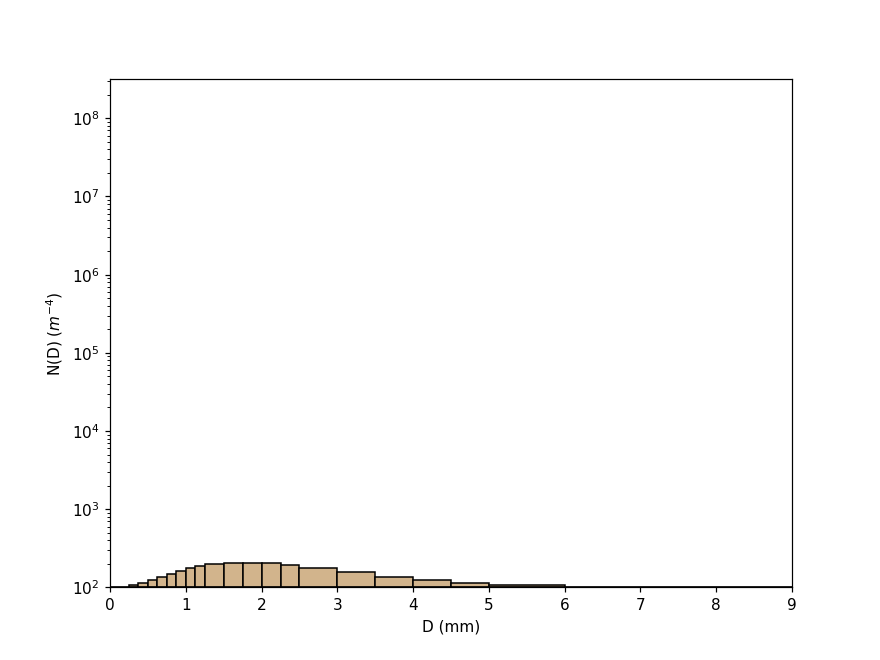

In [111]:
# Plot ND along with sampled ND
tindex = 7
ax = plotDSD(Dl*1000., D*1000., Dr*1000., 1000.*Nc_bin[tindex,:])
ax.bar(Dl[:Dmax_index+1]*1000., 1000.*Nc_bin2[tindex,:], (Dr-Dl)[:Dmax_index+1]*1000., 10.**2., align='edge', log=True, color='b', edgecolor = 'k', alpha=0.5)
plt.savefig('singleDSD_example.png',dpi=300)

In [32]:
# Read in disdrometer data from one of Glen's netCDF files
dis_dir = '/Users/dawson29/Dropbox/Projects/VORTEX2/Disdrometer_study/Glen_newdata/2009_06_05/'
dis_file_name = '2009_06_05_D1_DIS_P2.nc'
dis_path = os.path.join(dis_dir, dis_file_name)

pcount, pcounts_binned_obs, Nc_bin_obs, logNc_bin_obs, min_size, avg_size, max_size, bin_width, disdates = \
            dis.readdataGlennetCDF(dis_path)


In [44]:
print logNc_bin_obs.shape
print logNc_bin.shape

(32, 21)
(26, 32)


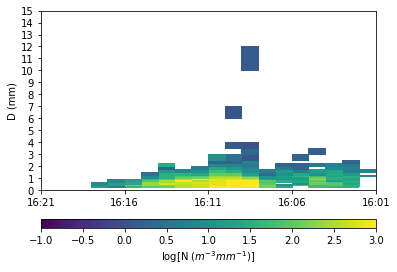

In [57]:
import matplotlib.dates as mpldates
plotparamdicts = [{'type': 'pcolor', 'vlimits': (-1.0, 3.0), 'clabel': r'log[N ($m^{-3} mm^{-1}$)]'}]
xvals = [mpldates.date2num(disdates)]
yvals = [Dl*1000.]
zvals = [logNc_bin_obs]
ax = pm.plotmeteogram(None, xvals, zvals, plotparamdicts, yvals=yvals)
axparamdicts = [{'majorxlocator': mpldates.MinuteLocator(interval=5),
                 'majorxformatter': mpldates.DateFormatter('%H:%M'),
                 'majorylocator': ticker.MultipleLocator(base=1.0),
                 'axeslimits': [None, (0.0, 15.0)],
                 'axeslabels': [None, 'D (mm)']}]
axlist = pm.set_meteogram_axes([ax], axparamdicts)
for ax in axlist:
    ax.invert_xaxis()

(83, 32)


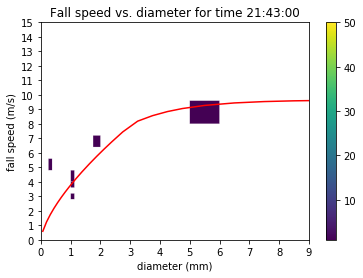

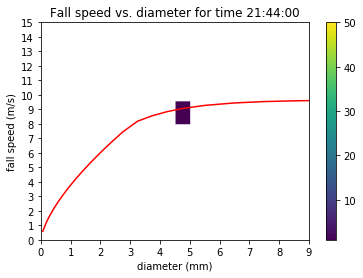

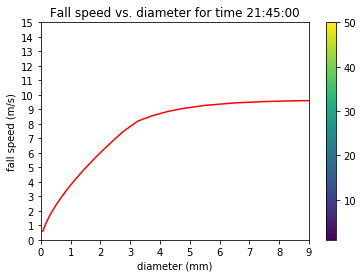

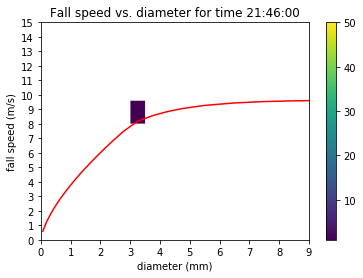

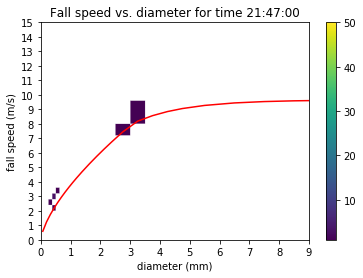

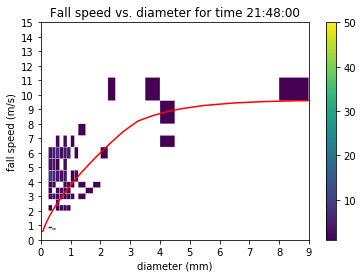

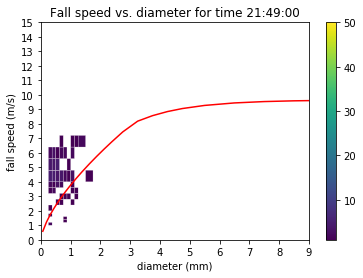

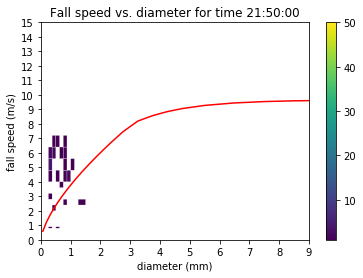

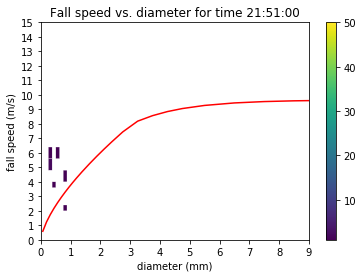

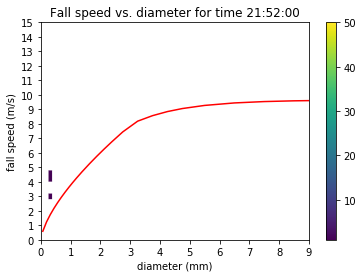

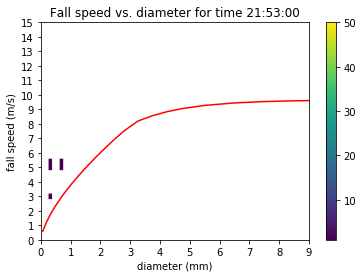

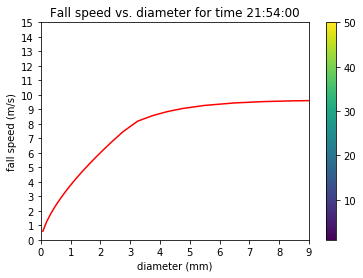

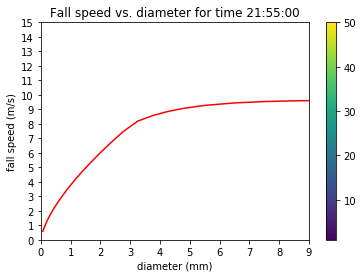

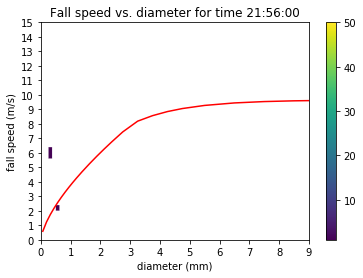

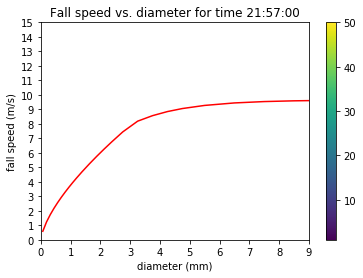

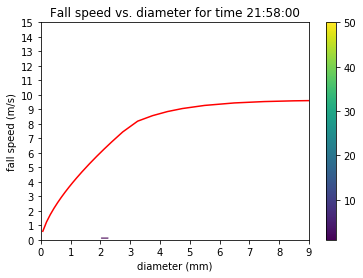

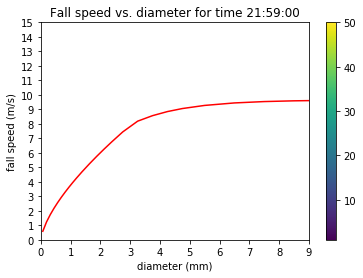

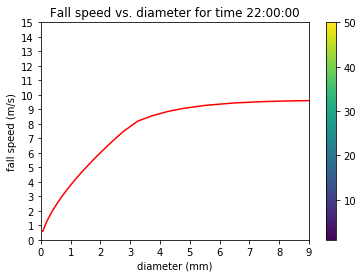

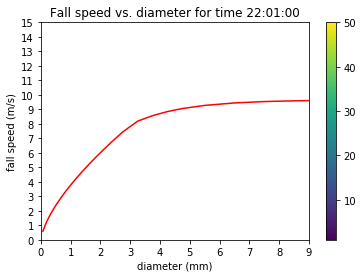

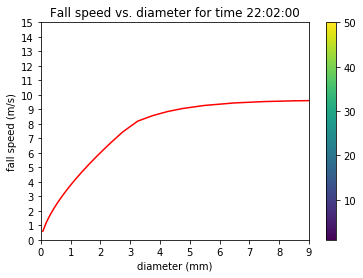

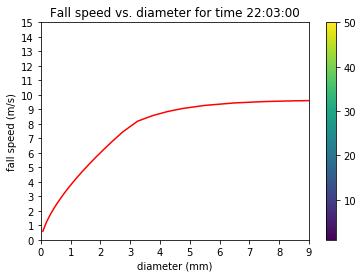

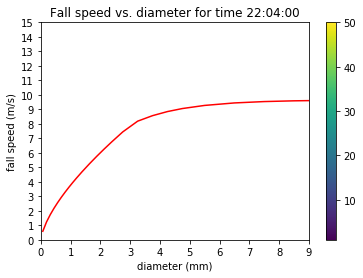

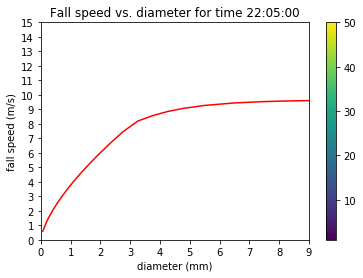

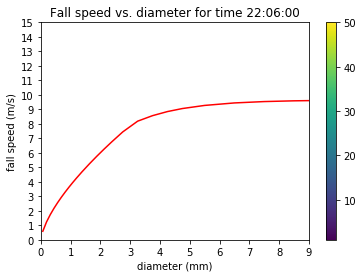

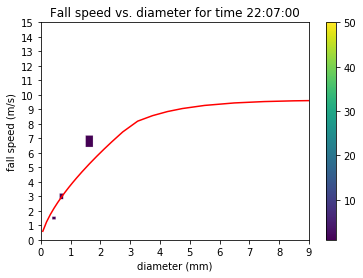

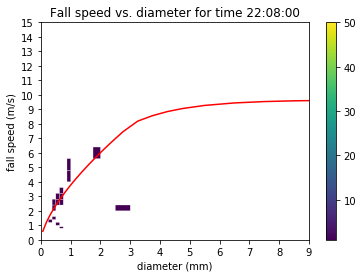

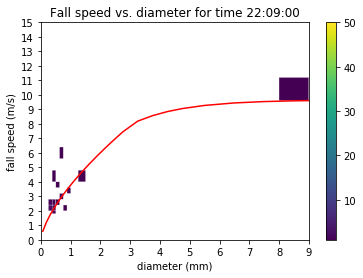

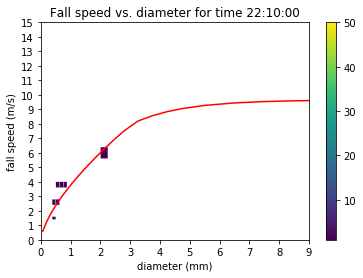

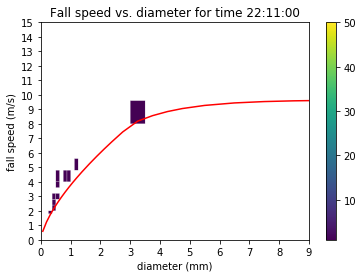

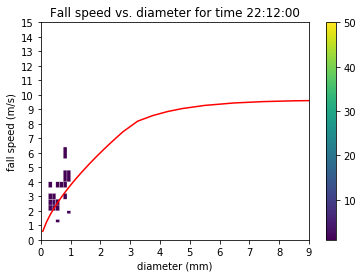

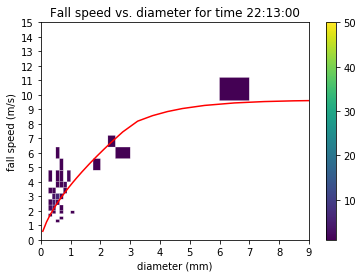

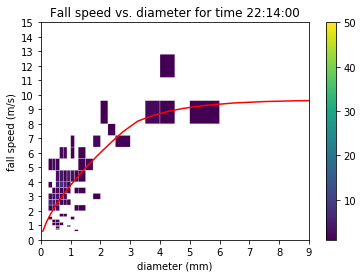

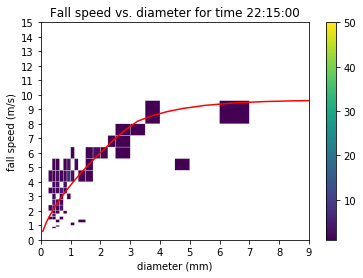

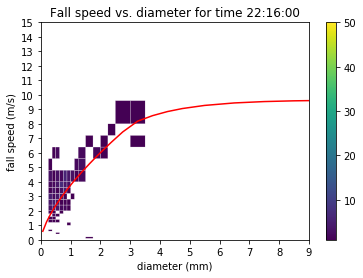

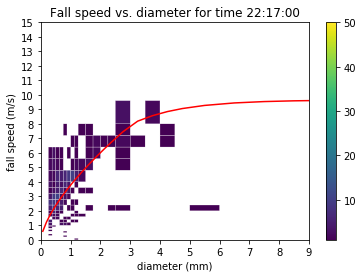

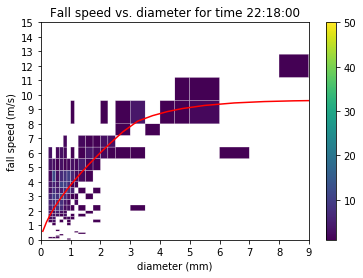

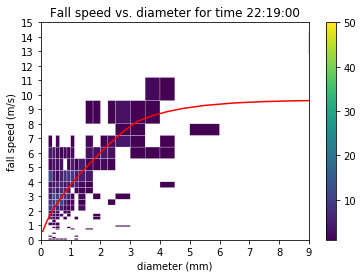

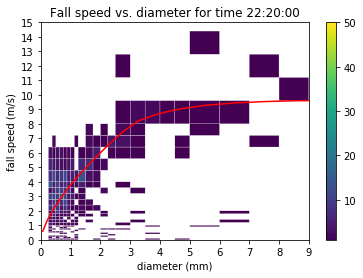

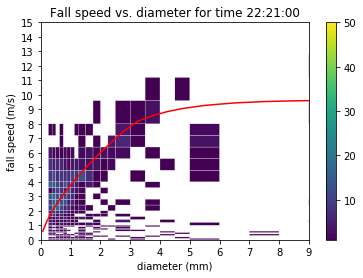

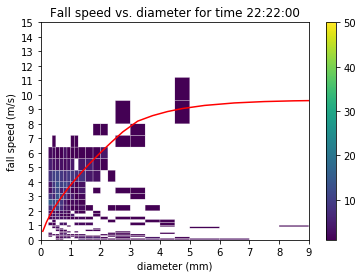

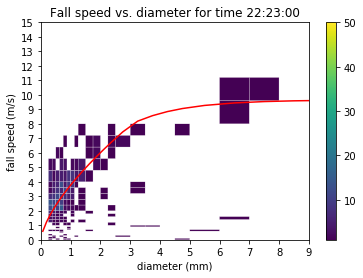

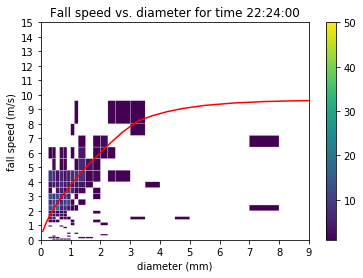

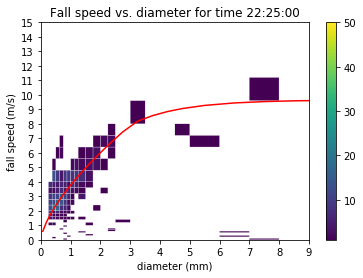

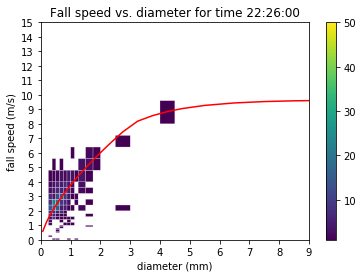

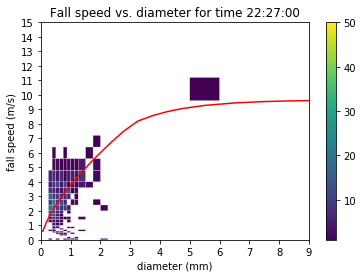

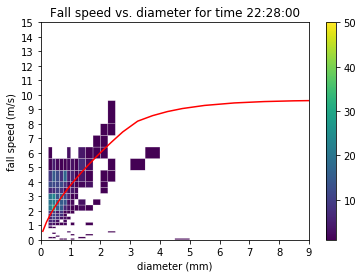

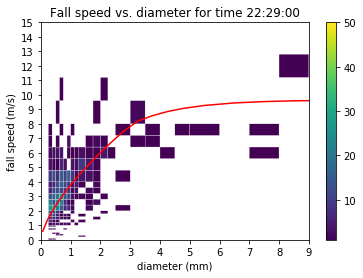

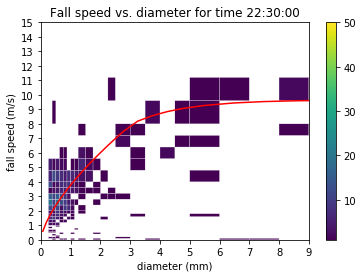

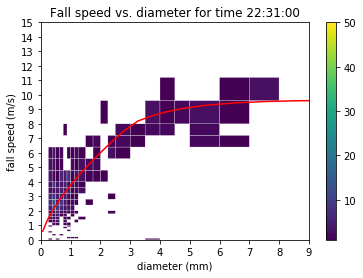

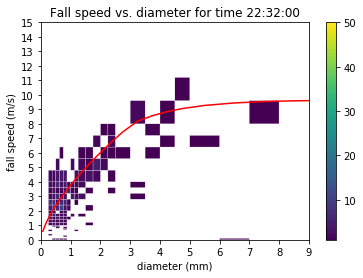

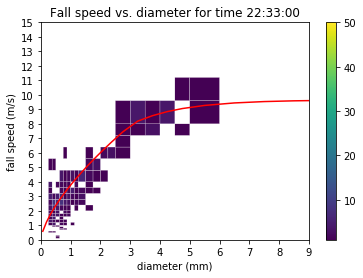

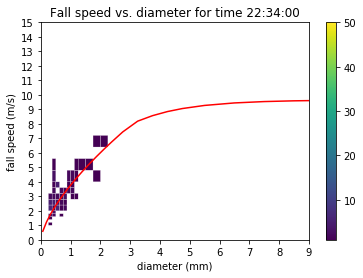

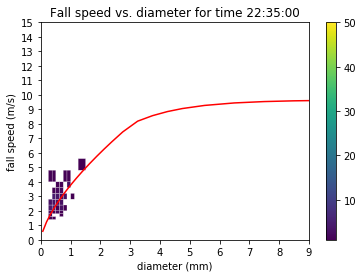

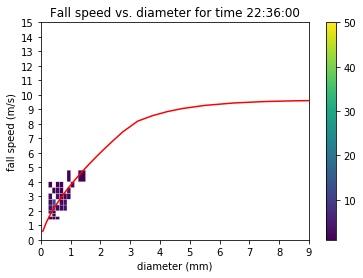

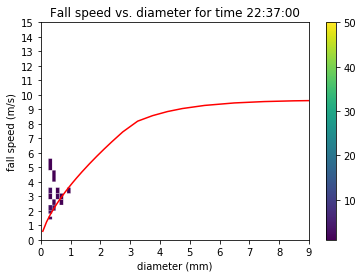

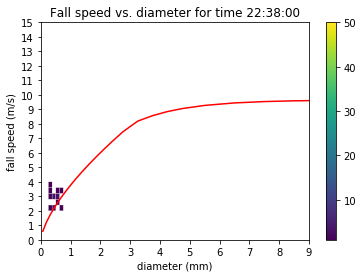

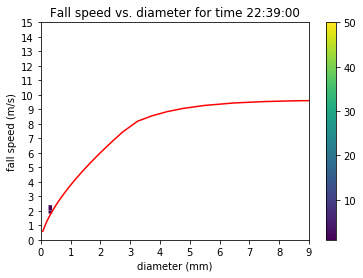

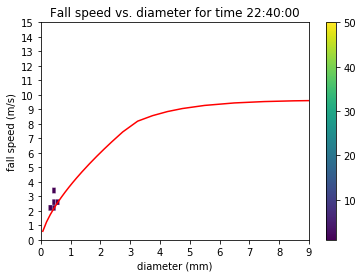

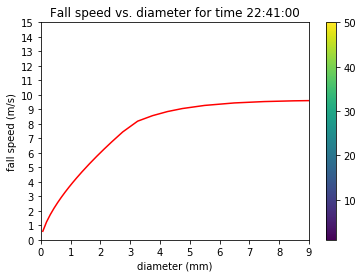

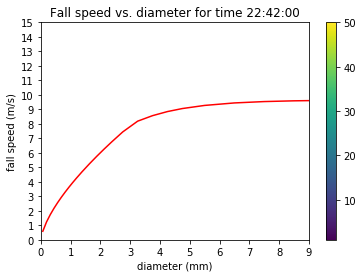

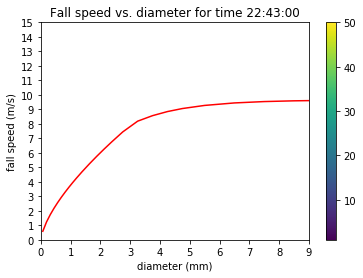

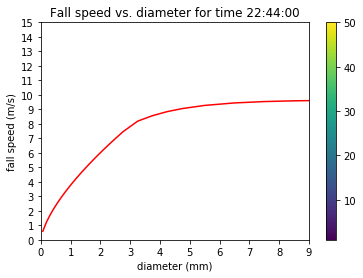

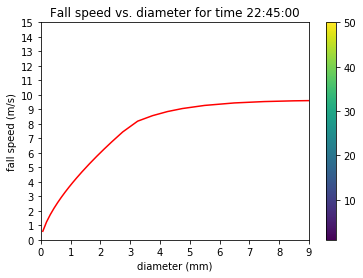

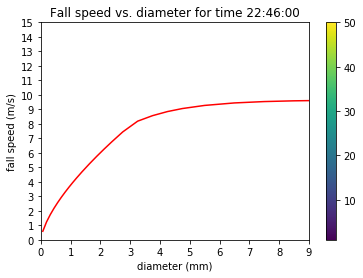

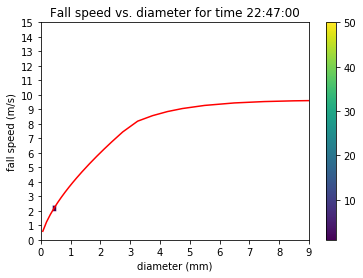

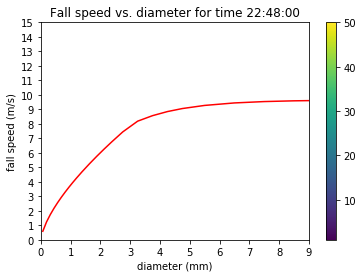

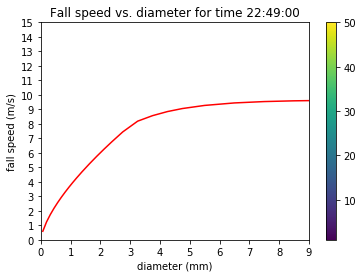

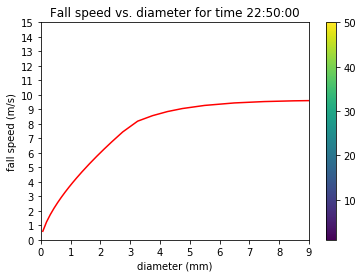

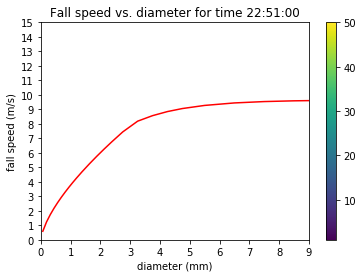

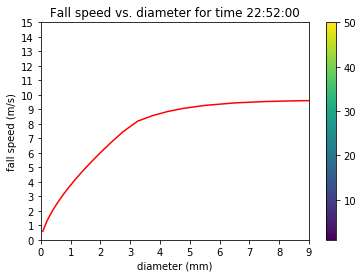

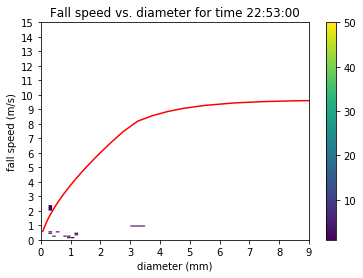

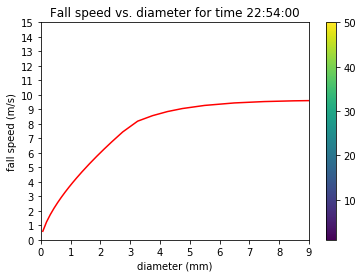

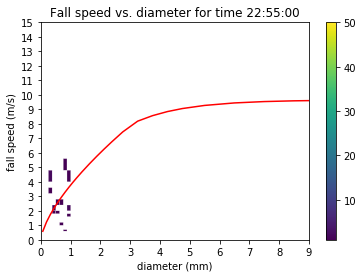

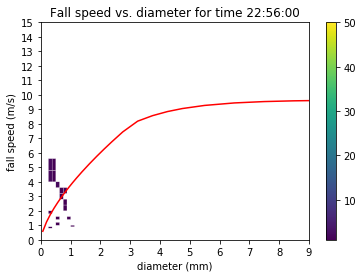

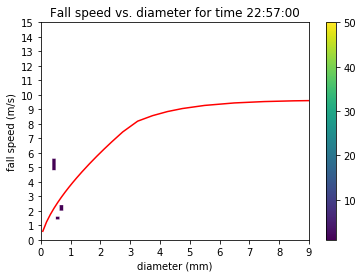

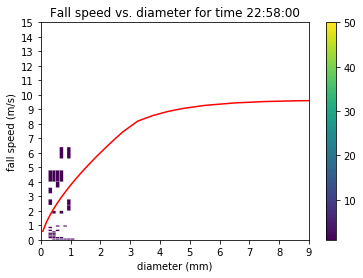

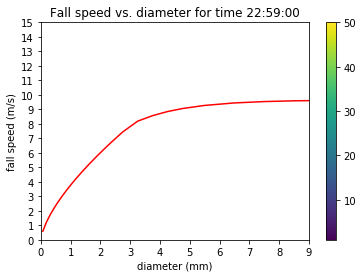

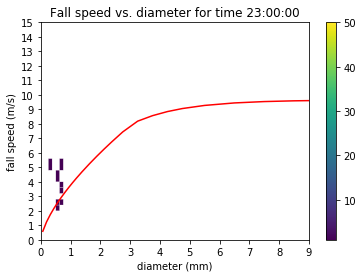

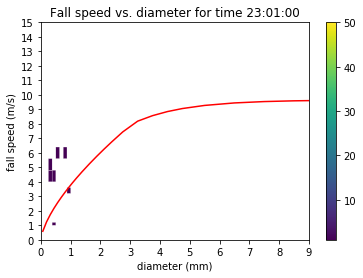

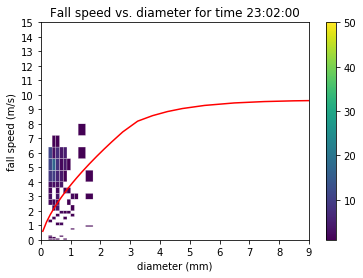

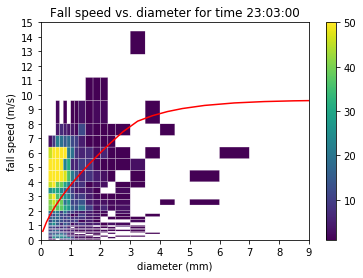

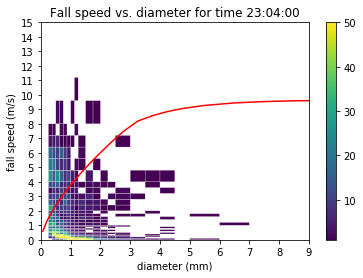

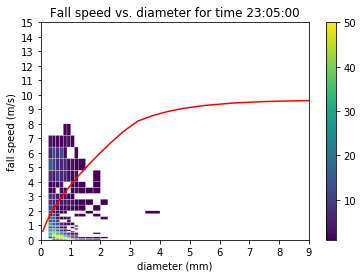

In [74]:
# Read in disdrometer data from one of Katja's text files
dis_dir = '/Users/dawson29/Dropbox/Projects/VORTEX2/Disdrometer_study/CU_data/disdrometer_data/20090605/'
dis_file_name = '20090605_PA01.txt'
conv_file_name = '20090605_CU01.dat'
dis_path = os.path.join(dis_dir, dis_file_name)
conv_path = os.path.join(dis_dir, conv_file_name)

starttime = None
endtime = None

dates,times,intensities,preciptots,weathercodes,reflectivities,visibilities,pcount,pcount2, \
               sensortemps,min_size,max_size,avg_size,Nc_bin_obs2 = dis.readdataCU(dis_path)

print Nc_bin_obs2.shape
year_end   = [int(date[6:10]) for date in dates]
month_end  = [int(date[3:5]) for date in dates]
day_end    = [int(date[:2]) for date in dates]
hour_end   = [int(time[:2]) for time in times]
min_end    = [int(time[3:5]) for time in times]
sec_end    = [int(time[6:8]) for time in times]

disdate_end = []
dis_startindex = 0
dis_endindex = len(year_end)
j = 0        
Nc_bin_temp = Nc_bin_obs2
pcount_temp = pcount
pcount2_temp = pcount2
for i in range(len(year_end)):
    distimeend = datetime(year_end[i],month_end[i],day_end[i],hour_end[i],min_end[i],sec_end[i])-timedelta(hours=6) # Get to CST time
    # There appear to be duplicate time records in some files, so check for them and throw them out
    # Although some of them seem to contain different data.  I need to check with Katja about this.
    if(i < len(year_end)-1):
        distimenext = datetime(year_end[i+1],month_end[i+1],day_end[i+1],hour_end[i+1],min_end[i+1],sec_end[i+1])-timedelta(hours=6) # Get to CST time
    else:
        distimenext = None
    if(distimeend != distimenext):
        # Find index corresponding to chosen start and endtimes
        if(mpldates.date2num(distimeend) == starttime):
            dis_startindex = j
        if(mpldates.date2num(distimeend) == endtime):
            dis_endindex = j
        disdate_end.append(distimeend)
        j = j + 1
    else:
        # Remove duplicate record from number concentration and pcount lists
        Nc_bin_temp = N.delete(Nc_bin_obs2,[i+1],axis=0)
        pcount_temp = N.delete(pcount,[i+1])
        pcount2_temp = N.delete(pcount2,[i+1])

Nc_bin_obs2 = Nc_bin_temp
pcount = pcount_temp
pcount2 = pcount2_temp

disdates = disdate_end[dis_startindex:dis_endindex+1]

#print "CU disdrometer times: ",disdates

bin_width = max_size-min_size

# Enhance small drops for testing if desired
if(False):
    Nc_bin[:,0:7] = Nc_bin[:,0:7]*enhancefactor

Nc_bin_obs2 = Nc_bin_obs2.T
logNc_bin_obs2 = np.ma.log10(Nc_bin_obs2)

#print Nc_bin
#print logNc_bin

#Restrict time dimension to start and end times
Nc_bin_obs2 = Nc_bin_obs2[:,dis_startindex:dis_endindex+1]
logNc_bin_obs2 = logNc_bin_obs2[:,dis_startindex:dis_endindex+1]
pcount = pcount[dis_startindex:dis_endindex+1]
pcount2 = pcount2[dis_startindex:dis_endindex+1]

#Nc_bin = N.ma.masked_array(Nc_bin,mask=N.where(Nc_bin == -999., True, False))
#logNc_bin = N.ma.masked_array(logNc_bin,mask=N.where(Nc_bin == -999., True, False))
logNc_bin_obs2 = np.ma.masked_where(Nc_bin_obs2 <= 0.0, logNc_bin_obs2)


(83, 32)
(32, 83)
0
84
(32, 83)


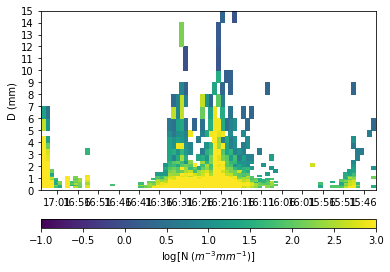

In [75]:
#Restrict time dimension to start and end times
print Nc_bin_temp.shape
print Nc_bin_obs2.shape
print dis_startindex
print dis_endindex+1
Nc_bin_obs2 = Nc_bin_obs2[:,dis_startindex:dis_endindex+1]
logNc_bin_obs2 = logNc_bin_obs2[:,dis_startindex:dis_endindex+1]
pcount = pcount[dis_startindex:dis_endindex+1]
pcount2 = pcount2[dis_startindex:dis_endindex+1]

#Nc_bin = N.ma.masked_array(Nc_bin,mask=N.where(Nc_bin == -999., True, False))
#logNc_bin = N.ma.masked_array(logNc_bin,mask=N.where(Nc_bin == -999., True, False))
logNc_bin_obs2 = np.ma.masked_where(Nc_bin_obs2 <= 0.0, logNc_bin_obs2)
print logNc_bin_obs2.shape
plotparamdicts = [{'type': 'pcolor', 'vlimits': (-1.0, 3.0), 'clabel': r'log[N ($m^{-3} mm^{-1}$)]'}]
xvals = [mpldates.date2num(disdates)]
yvals = [Dl*1000.]
zvals = [logNc_bin_obs2]
ax = pm.plotmeteogram(None, xvals, zvals, plotparamdicts, yvals=yvals)
axparamdicts = [{'majorxlocator': mpldates.MinuteLocator(interval=5),
                 'majorxformatter': mpldates.DateFormatter('%H:%M'),
                 'majorylocator': ticker.MultipleLocator(base=1.0),
                 'axeslimits': [None, (0.0, 15.0)],
                 'axeslabels': [None, 'D (mm)']}]
axlist = pm.set_meteogram_axes([ax], axparamdicts)
for ax in axlist:
    ax.invert_xaxis()

In [100]:
import shlex
conv_file_name = '20090605_CU1.dat'
conv_path = os.path.join(dis_dir, conv_file_name)

matchtimes = True

pdatetimes = []
with open(dis_path, 'r') as disfile:
    for line in disfile:
        tokens = line.strip().split(';')
        # print line
        date = tokens[0]
        time = tokens[1]

        # Construct datetime object
        day = int(date[0:2])
        month = int(date[3:5])
        year = int(date[6:10])
        hour = int(time[0:2])
        min = int(time[3:5])
        sec = int(time[6:8])

        pdatetimes.append(datetime(year, month, day, hour, min, sec))

datetimes = []
with open(conv_path, 'r') as convfile:
    # Read in the header information

    dummy = convfile.readline()
    dummy = convfile.readline()
    dummy = convfile.readline()
    dummy = convfile.readline()

    for line in convfile:
        mysplit = shlex.shlex(line)
        mysplit.whitespace += ','
        mysplit.whitespace_split = True
        #line = l.strip().split(',')
        tokens = list(mysplit)
        datetimestring = tokens[0]

        # Construct datetime object
        year = int(datetimestring[1:5])
        month = int(datetimestring[6:8])
        day = int(datetimestring[9:11])
        hour = int(datetimestring[12:14])
        min = int(datetimestring[15:17])
        sec = int(datetimestring[18:20])

        datetimelogger = datetime(year, month, day, hour, min, sec)
        # Skip this record if it lies before or after the Parsivel file time period
        if matchtimes and (datetimelogger < pdatetimes[0] or datetimelogger > pdatetimes[-1]):
            continue
        datetimes.append(datetimelogger)


pindices = np.searchsorted(datetimes, pdatetimes)
print type(pindices)
print pdatetimes
print datetimes
print datetimes[pindices]

<type 'numpy.ndarray'>
[datetime.datetime(2009, 6, 5, 21, 43), datetime.datetime(2009, 6, 5, 21, 44), datetime.datetime(2009, 6, 5, 21, 45), datetime.datetime(2009, 6, 5, 21, 46), datetime.datetime(2009, 6, 5, 21, 47), datetime.datetime(2009, 6, 5, 21, 48), datetime.datetime(2009, 6, 5, 21, 49), datetime.datetime(2009, 6, 5, 21, 50), datetime.datetime(2009, 6, 5, 21, 51), datetime.datetime(2009, 6, 5, 21, 52), datetime.datetime(2009, 6, 5, 21, 53), datetime.datetime(2009, 6, 5, 21, 54), datetime.datetime(2009, 6, 5, 21, 55), datetime.datetime(2009, 6, 5, 21, 56), datetime.datetime(2009, 6, 5, 21, 57), datetime.datetime(2009, 6, 5, 21, 58), datetime.datetime(2009, 6, 5, 21, 59), datetime.datetime(2009, 6, 5, 22, 0), datetime.datetime(2009, 6, 5, 22, 1), datetime.datetime(2009, 6, 5, 22, 2), datetime.datetime(2009, 6, 5, 22, 3), datetime.datetime(2009, 6, 5, 22, 4), datetime.datetime(2009, 6, 5, 22, 5), datetime.datetime(2009, 6, 5, 22, 6), datetime.datetime(2009, 6, 5, 22, 7), datetime.

TypeError: only integer scalar arrays can be converted to a scalar index

In [98]:
interval = pdatetimes[1]-pdatetimes[0]
print interval
print np.float(interval.seconds)

0:01:00
60.0
